## Remarks:

*   Load time series: 2013 --> reindexed to 2025 --> finding more updated load data (next steps)
*   Weather Data: 2025
*   Distribute load based on GDP for regions (next steps)
*   Placing the off_wind in eez areas, not the neighboring states (next steps)
*   fossil technologies considered are only: oil, gas (CCGT), and nuclear
*   gas is considered only as CCGT power plant (for marginal Cost calculation of power plant)
*   StorageUnit consideration: only "battery storage (2, 4, 6 hours)" & "hydrogen storage tank type 1 (168, 336, 672 hours)"
*   the model is 3 hourly, try an hourly model (next steps)
*   consideration of ramp_up and down (time and costs) --> different results for nuclear probably

## Open To Do:

*   plotting the results (which results we wanna look at??)
*   Sensitivity Analysis

## preparing and inspecting the data

In [1]:
import linopy
import pypsa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import cartopy
import cartopy.crs as ccrs

import networkx as nx

import atlite
from atlite.gis import ExclusionContainer, shape_availability
from rasterio.plot import show
from rasterio.crs import CRS
import rasterio as rio

from pathlib import Path
import xarray as xr

Finding more data on Iran: Iran Open Data https://iranopendata.org/en/

all data provided from TU Berlin can be found here:
https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq

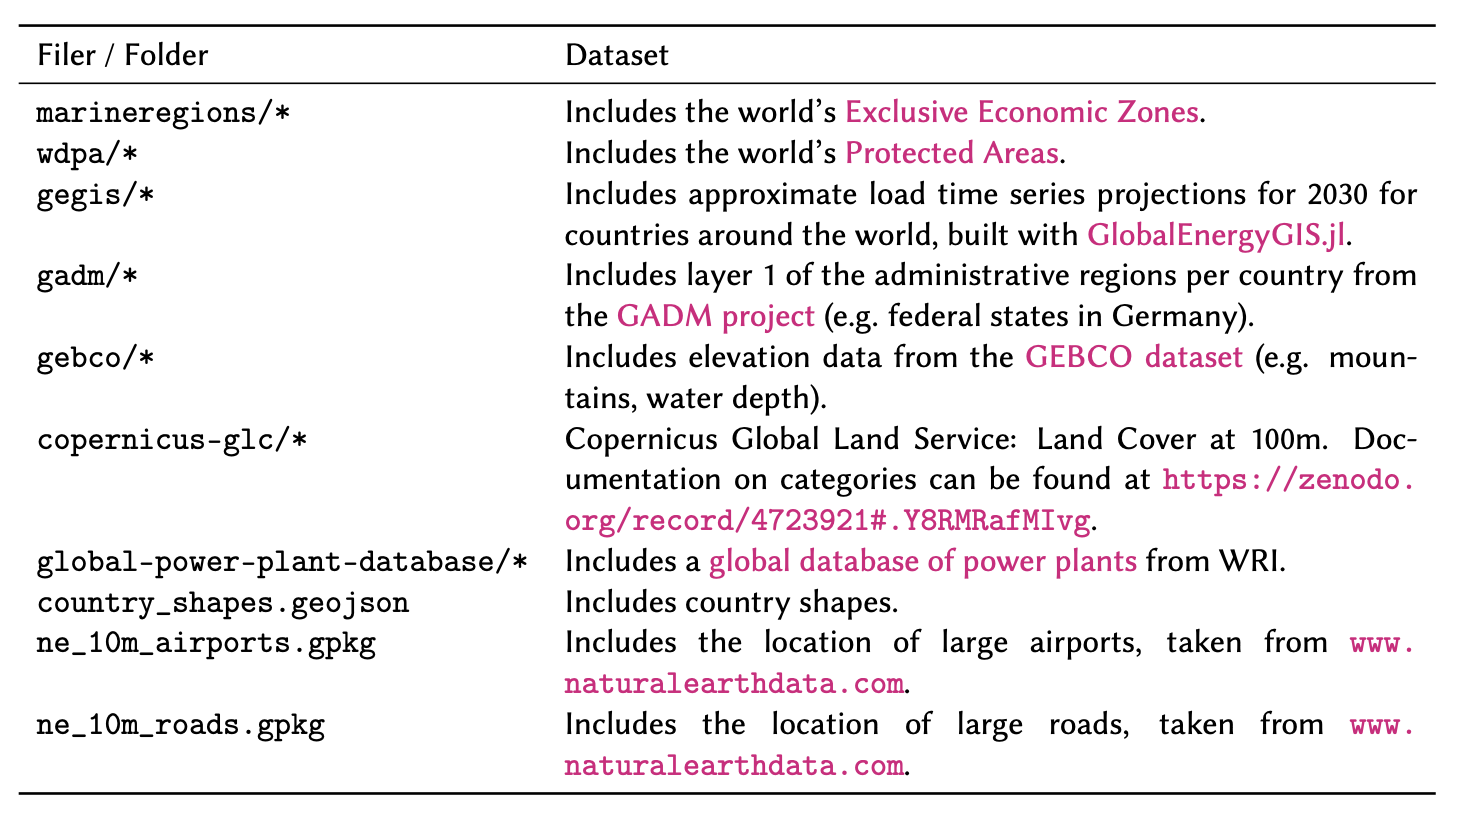

also data on technology and cost assumptions can be found here: https://github.com/PyPSA/technology-data/tree/master/outputs 

global power plant database: https://datasets.wri.org/datasets/global-power-plant-database

In [2]:
url_airports = Path("data") / "ne_10m_airports.gpkg"
url_roads = Path("data") / "ne_10m_roads.gpkg"

url_countries_local = Path("data") / "country_shapes.geojson"
url_gadm_local = Path("data") / "gadm_410-levels-ADM_1-IRN.gpkg"
url_eez_local = Path("data") / "eez_v11.gpkg" 
url_eez_ir_local = Path("data") / "eez_ir.gpkg"

url_wdpa_local =  Path("data") / "WDPA_Oct2022_Public_shp-IRN.tif"
url_gebco_local = Path("data") / "GEBCO_2014_2D-IR.nc"
url_gebco_tif_local = Path("data") / "gebco_2025_n41.0_s21.0_w44.0_e64.0.tif"

url_load = Path("data") / "load.csv"
url_population = Path("data") / "population.CSV"

url_power_plants = Path("data") / "global_power_plant_database.csv"

url_glc_local = Path("data") / "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-IR.tif"

COST_YEAR = 2025
url_costs = Path("data") / f"costs_{COST_YEAR}.csv"

url_era5 = Path("data") / "era5-2025-IR.nc"

# The unit of measurement for both projections is metres.
AREA_CRS = "ESRI:54009"
DISTANCE_CRS = "EPSG:4087"

### getting the shape of the country

In [3]:
countries = gpd.read_file(url_countries_local).set_index("name")

# storing shape of the country so it can be used in further steps
shape_ir = countries.to_crs(epsg=3035).loc[["IR"]].geometry

### preparing exclusive economics zone EEZ and states of iran GADM

In [4]:
# preparing the exclusive economice zone of Iran for Wind off-shore analysis
"""eez_ir.to_file(
    "data/eez_ir.gpkg",
    driver="GPKG"
)"""


"""eez = gpd.read_file(url_eez_local)
eez_ir = eez[eez["SOVEREIGN1"] == "Iran"]

# Also add Buses for Off-Shore Regions
eez_ir = eez_ir.explode(index_parts=True) # dividing eez_ir to two parts (one in north and one in south)"""
eez_ir = gpd.read_file(url_eez_ir_local)

#eez_ir["bus"] = eez_ir.geometry.centroid # defining the centroid of eez in north and south to be used as bus for pypsa
eez_ir["bus"] = eez_ir.geometry.representative_point() # defining the representative of eez in north and south to be used as bus for pypsa
eez_ir

level_0  level_1   MRGID                          GEONAME  MRGID_TER1  \
0      162        0  8469.0  Iranian Exclusive Economic Zone      2126.0   
1      162        1  8469.0  Iranian Exclusive Economic Zone      2126.0   

  POL_TYPE  MRGID_SOV1 TERRITORY1 ISO_TER1 SOVEREIGN1  ...  ISO_SOV2  \
0    200NM      2126.0       Iran      IRN       Iran  ...      None   
1    200NM      2126.0       Iran      IRN       Iran  ...      None   

   ISO_SOV3 UN_SOV1 UN_SOV2 UN_SOV3  UN_TER1  UN_TER2 UN_TER3  \
0      None     364     NaN     NaN    364.0      NaN     NaN   
1      None     364     NaN     NaN    364.0      NaN     NaN   

                                            geometry  \
0  POLYGON ((56.087 27.10831, 56.08874 27.11032, ...   
1  POLYGON ((51.53862 38.28868, 51.56252 38.27008...   

                         bus  
0  POINT (51.77763 27.26739)  
1  POINT (51.06546 37.62921)  

[2 rows x 35 columns]

In [5]:
# preparing the data of states of Iran
gadm_ir = gpd.read_file(url_gadm_local)
#gadm_ir["bus"] = gadm_ir.geometry.centroid # to be used as bus for modeling
gadm_ir["bus"] = gadm_ir.geometry.representative_point() # to be used as bus for modeling
gadm_ir

GID_0     GID_1 COUNTRY                       NAME_1  \
0    IRN   IRN.1_1    Iran                       Alborz   
1    IRN   IRN.2_1    Iran                      Ardebil   
2    IRN   IRN.3_1    Iran                      Bushehr   
3    IRN   IRN.4_1    Iran  Chahar Mahall and Bakhtiari   
4    IRN   IRN.5_1    Iran              East Azarbaijan   
5    IRN   IRN.6_1    Iran                      Esfahan   
6    IRN   IRN.7_1    Iran                         Fars   
7    IRN   IRN.8_1    Iran                        Gilan   
8    IRN   IRN.9_1    Iran                     Golestan   
9    IRN  IRN.10_1    Iran                      Hamadan   
10   IRN  IRN.11_1    Iran                    Hormozgan   
11   IRN  IRN.12_1    Iran                         Ilam   
12   IRN  IRN.13_1    Iran                       Kerman   
13   IRN  IRN.14_1    Iran                   Kermanshah   
14   IRN  IRN.15_1    Iran                    Khuzestan   
15   IRN  IRN.16_1    Iran   Kohgiluyeh and Buyer Ahmad   
16   IRN  IRN.17_1    Iran                    Kordestan   
17   IRN  IRN.18_1    Iran                     Lorestan   
18   IRN  IRN.19_1    Iran                      Markazi   
19   IRN  IRN.20_1    Iran                   Mazandaran   
20   IRN  IRN.21_1    Iran               North Khorasan   
21   IRN  IRN.22_1    Iran                       Qazvin   
22   IRN  IRN.23_1    Iran                          Qom   
23   IRN  IRN.24_1    Iran              Razavi Khorasan   
24   IRN  IRN.25_1    Iran                       Semnan   
25   IRN  IRN.26_1    Iran       Sistan and Baluchestan   
26   IRN  IRN.27_1    Iran               South Khorasan   
27   IRN  IRN.28_1    Iran                       Tehran   
28   IRN  IRN.29_1    Iran              West Azarbaijan   
29   IRN  IRN.30_1    Iran                         Yazd   
30   IRN  IRN.31_1    Iran                       Zanjan   

                                             geometry  \
0   MULTIPOLYGON (((51.11609 35.73298, 51.14558 35...   
1   MULTIPOLYGON (((48.50534 38.02509, 48.48986 38...   
2   MULTIPOLYGON (((52.67042 27.4607, 52.67042 27....   
3   MULTIPOLYGON (((51.14743 32.18388, 51.15947 32...   
4   MULTIPOLYGON (((46.38165 36.97453, 46.37059 36...   
5   MULTIPOLYGON (((51.22968 31.71423, 51.24065 31...   
6   MULTIPOLYGON (((52.9134 27.41733, 52.91028 27....   
7   MULTIPOLYGON (((50.01936 36.64008, 49.99538 36...   
8   MULTIPOLYGON (((53.74197 36.80078, 53.76437 36...   
9   MULTIPOLYGON (((48.52959 34.05629, 48.51778 34...   
10  MULTIPOLYGON (((55.04125 25.8982, 55.04125 25....   
11  MULTIPOLYGON (((47.84772 32.466, 47.82745 32.4...   
12  MULTIPOLYGON (((58.83803 26.02069, 58.83016 26...   
13  MULTIPOLYGON (((45.80491 33.97298, 45.81714 33...   
14  MULTIPOLYGON (((49.0867 30.10403, 49.08677 30....   
15  MULTIPOLYGON (((50.5899 30.1543, 50.57806 30.1...   
16  MULTIPOLYGON (((47.17719 34.96043, 47.16431 34...   
17  MULTIPOLYGON (((49.94793 33.32036, 49.93667 33...   
18  MULTIPOLYGON (((50.39845 33.66849, 50.37521 33...   
19  MULTIPOLYGON (((52.24207 35.86028, 52.23634 35...   
20  MULTIPOLYGON (((58.00188 37.06804, 57.98917 37...   
21  MULTIPOLYGON (((50.35007 35.87881, 50.30336 35...   
22  MULTIPOLYGON (((51.78895 34.54203, 51.77748 34...   
23  MULTIPOLYGON (((58.63802 34.07865, 58.67223 34...   
24  MULTIPOLYGON (((52.75356 34.35786, 52.70595 34...   
25  MULTIPOLYGON (((59.8932 25.34542, 59.89403 25....   
26  MULTIPOLYGON (((60.8224 32.02665, 60.81478 31....   
27  MULTIPOLYGON (((51.80992 34.91453, 51.76239 34...   
28  MULTIPOLYGON (((45.69785 36.21315, 45.68772 36...   
29  MULTIPOLYGON (((53.63807 30.76514, 53.62657 30...   
30  MULTIPOLYGON (((48.47335 35.63638, 48.46114 35...   

                          bus  
0     POINT (50.85749 35.942)  
1   POINT (47.94104 38.42274)  
2    POINT (51.4917 28.79621)  
3   POINT (50.70829 31.87909)  
4   POINT (46.48105 38.05469)  
5   POINT (52.02162 32.65634)  
6   POINT (53.07974 29.42908)  
7   POINT (49.02206 37.50495)  
8

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_90260/3772176604.py:11: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler

/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



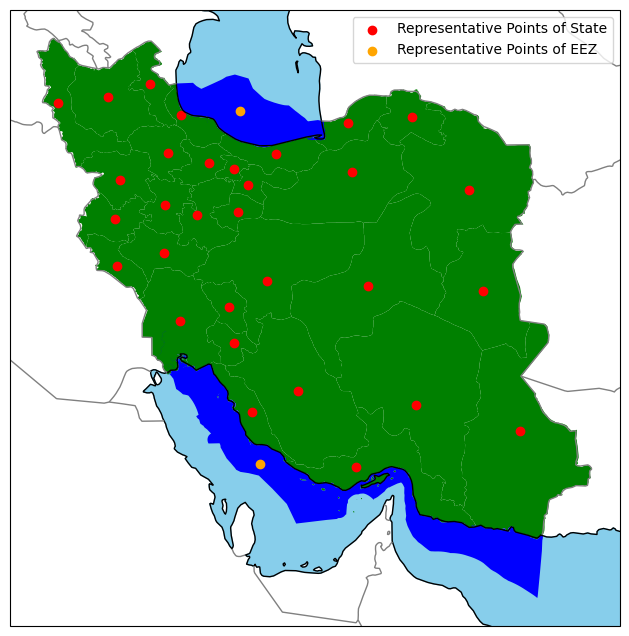

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

gadm_ir.plot(ax=ax, color="green", label="States of Iran")
eez_ir.plot(ax=ax, color="blue", label="Exclusive Economic Zones of Iran")

gadm_ir.bus.plot(ax=ax, color="red", label="Representative Points of State") # center of each state to be used as bus for modelling
eez_ir.bus.plot(ax=ax, color="Orange", label="Representative Points of EEZ") # center of each Off-shore area, to be used as bus for modelling

ax.coastlines()
ax.legend()

#ax.set_extent([44, 64, 24, 41], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, color="gray")
ax.add_feature(cartopy.feature.OCEAN, color="skyblue")
#ax.add_feature(cartopy.feature.LAND, color="lightgreen")

### world's protected areas from WDPA

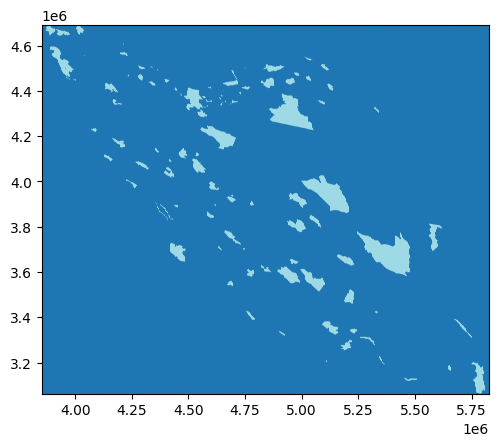

In [7]:
"""
# world's protected areas
wdpa_ir = rio.open(url_wdpa_local)
band_wdpa = wdpa_ir.read(1)

show(band_wdpa, transform=wdpa_ir.transform, cmap="tab20")"""

'\n# world\'s protected areas\nwdpa_ir = rio.open(url_wdpa_local)\nband_wdpa = wdpa_ir.read(1)\n\nshow(band_wdpa, transform=wdpa_ir.transform, cmap="tab20")'

### Elevation Data from GEBCO dataset

In [8]:
"""gebco_tif_ir = rio.open(url_gebco_tif_local)
band_gebco = gebco_tif_ir.read(1)

show(band_gebco, transform=gebco_tif_ir.transform, cmap="tab20")"""



'gebco_tif_ir = rio.open(url_gebco_tif_local)\nband_gebco = gebco_tif_ir.read(1)\n\nshow(band_gebco, transform=gebco_tif_ir.transform, cmap="tab20")'

In [9]:
import os
os.environ["GDAL_SKIP"] = "netCDF"

gebco_ir = rio.open(url_gebco_local, driver="HDF5")
band_gebco = gebco_ir.read(1)

# flip the band_gebco upside down
#band_gebco = np.flipud(band_gebco)

"""
fig, ax = plt.subplots(figsize=(6, 8))

#shape_ir.boundary.to_crs(4326).plot(ax=ax, color="black", linewidth=1)

show(band_gebco, transform=gebco_ir.transform, cmap="RdBu_r", ax=ax, vmin=-5500, vmax=5500)

plt.colorbar(ax.images[0], ax=ax, label="Elevation (m)", shrink=0.5)

# is the orientation correct??????????????
"""

/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/rasterio/__init__.py:367: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.



'\nfig, ax = plt.subplots(figsize=(6, 8))\n\n#shape_ir.boundary.to_crs(4326).plot(ax=ax, color="black", linewidth=1)\n\nshow(band_gebco, transform=gebco_ir.transform, cmap="RdBu_r", ax=ax, vmin=-5500, vmax=5500)\n\nplt.colorbar(ax.images[0], ax=ax, label="Elevation (m)", shrink=0.5)\n\n# is the orientation correct??????????????\n'

Driver: HDF5Image
Size (HxW): 1971 2316
Count (bands): 1
Transform:
 | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=0.0, bottom=1971.0, right=2316.0, top=0.0)
CRS: None
NoData: None


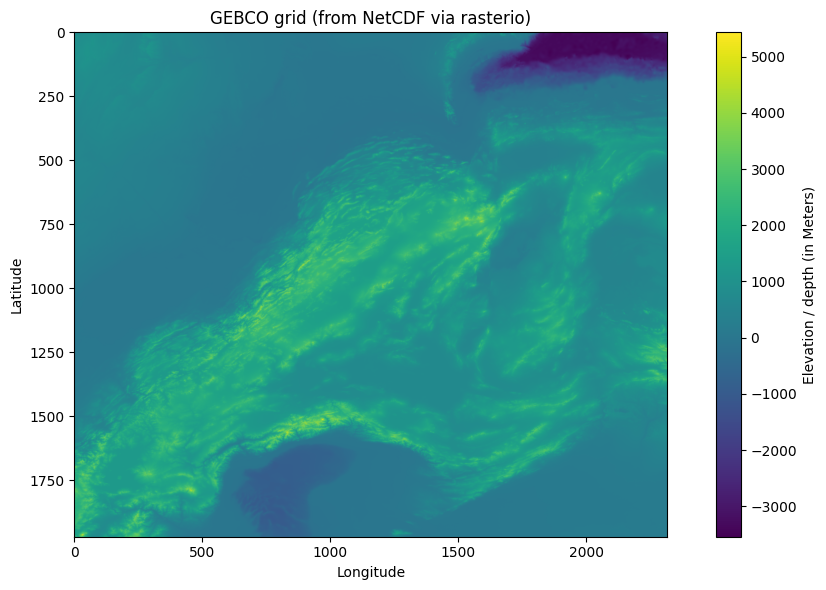

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#path = "/mnt/data/GEBCO_2014_2D-IR.nc"

with rasterio.open(url_gebco_local) as ds:
    print("Driver:", ds.driver)
    print("Size (HxW):", ds.height, ds.width)
    print("Count (bands):", ds.count)
    print("Transform:\n", ds.transform)
    print("Bounds:", ds.bounds)
    print("CRS:", ds.crs)
    print("NoData:", ds.nodata)

    # Read the first band
    z = ds.read(1).astype("float32")
    #z = np.flipud(z)

    # Mask NoData (your file uses -32767)
    #if ds.nodata is not None:
    #    z[z == ds.nodata] = np.nan

    # Build extent in lon/lat from raster bounds
    extent = [ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top]

# Plot
plt.figure(figsize=(10, 6))
im = plt.imshow(z, extent=extent, origin="upper")  # origin="upper" matches north-up rasters
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GEBCO grid (from NetCDF via rasterio)")
plt.colorbar(im, label="Elevation / depth (in Meters)")
plt.tight_layout()
plt.show()

### Load Time Seires

In [11]:
"""# load time series for whole year of 2013
url_load = Path("data") / "load.csv"
load = pd.read_csv(url_load, index_col=0, parse_dates=True)
load_ir = load.IR
load_ir # in MW"""

'# load time series for whole year of 2013\nurl_load = Path("data") / "load.csv"\nload = pd.read_csv(url_load, index_col=0, parse_dates=True)\nload_ir = load.IR\nload_ir # in MW'

In [12]:
# call data
# load time series for whole year of 2013
# regional population dataframe of Iran 2024
#url_load = "/content/load.csv"
load = pd.read_csv(url_load, index_col=0, parse_dates=True)
pop = pd.read_csv(url_population, index_col=0).set_index("province")

#isolate iran load data, keep as frame
load_ir = load.IR.to_frame() # in MW

#convert population datatype to float
pop["population - 2024"] = pop["population - 2024"].str.replace(",","", regex=False)
pop = pop.astype(float)

#establish regional percentage share of population
pop_tot = pop.head(1).values
pop_reg = pop.tail(-1)
perc_reg = pop_reg/pop_tot #df

#aggregate load by region and population share
load_reg_1h = pd.DataFrame(
    load_ir.values @ perc_reg.values.T,
    index=load_ir.index,
    columns=perc_reg.index
)

load_reg_1h.sort_index(axis=1, inplace=True) # sorting the columns alphabetically 
load_reg_1h #hourly load time series by region

#adjust resolution if needed
#load_reg_3h = load_reg_1h.resample("3H").mean()
#load_reg_2h = load_reg_1h.resample("2H").mean()

province                  Alborz     Ardabil     Bushehr  \
time                                                       
2013-01-01 00:00:00  1572.198298  674.466839  663.043998   
2013-01-01 01:00:00  1639.287852  703.247992  691.337710   
2013-01-01 02:00:00  1832.671702  786.208897  772.893581   
2013-01-01 03:00:00  1922.627342  824.799510  810.830620   
2013-01-01 04:00:00  1969.770980  845.023944  830.712530   
...                          ...         ...         ...   
2013-12-31 19:00:00  1841.895766  790.165984  776.783650   
2013-12-31 20:00:00  1607.496434  689.609600  677.930299   
2013-12-31 21:00:00  1558.007636  668.379101  657.059363   
2013-12-31 22:00:00  1537.523794  659.591614  648.420702   
2013-12-31 23:00:00  1528.265324  655.619767  644.516122   

province             Chaharmahal and Bakhtiari  East Azerbaijan         Fars  \
time                                                                           
2013-01-01 00:00:00                 517.662385      2124.648426  2666.714154   
2013-01-01 01:00:00                 539.752308      2215.312381  2780.509381   
2013-01-01 02:00:00                 603.425920      2476.648812  3108.521090   
2013-01-01 03:00:00                 633.044736      2598.213700  3261.101067   
2013-01-01 04:00:00                 648.567261      2661.923002  3341.064648   
...                                        ...              ...          ...   
2013-12-31 19:00:00                 606.463038      2489.114093  3124.166662   
2013-12-31 20:00:00                 529.284658      2172.349871  2726.585761   
2013-12-31 21:00:00                 512.989965      2105.471350  2642.644392   
2013-12-31 22:00:00                 506.245450      2077.789750  2607.900332   
2013-12-31 23:00:00                 503.197004      2065.277974  2592.196401   

province                   Gilan     Golestan      Hamadan    Hormozgan  ...  \
time                                                                     ...   
2013-01-01 00:00:00  1333.876297  1046.747612   918.500261  1047.786052  ...   
2013-01-01 01:00:00  1390.796067  1091.414897   957.694917  1092.497650  ...   
2013-01-01 02:00:00  1554.865786  1220.167157  1070.672470  1221.377640  ...   
2013-01-01 03:00:00  1631.185483  1280.058363  1123.225815  1281.328262  ...   
2013-01-01 04:00:00  1671.182843  1311.445936  1150.767788  1312.746974  ...   
...                          ...          ...          ...          ...  ...   
2013-12-31 19:00:00  1562.691619  1226.308409  1076.061298  1227.524985  ...   
2013-12-31 20:00:00  1363.823758  1070.248617   939.121926  1071.310371  ...   
2013-12-31 21:00:00  1321.836729  1037.299668   910.209877  1038.328735  ...   
2013-12-31 22:00:00  1304.457935  1023.661812   898.242930  1024.677350  ...   
2013-12-31 23:00:00  1296.602912  1017.497653   892.834002  1018.507075  ...   

province                 Qazvin         Qom  Razavi Khorasan      Semnan  \
time                                                                       
2013-01-01 00:00:00  698.870181  754.945946      3691.135304  408.626176   
2013-01-01 01:00:00  728.692684  787.161340      3848.645092  426.063256   
2013-01-01 02:00:00  814.655254  880.021352      4302.662856  476.325175   
2013-01-01 03:00:00  854.642141  923.216696      4513.856597  499.705323   
2013-01-01 04:00:00  875.598329  945.854361      4624.538275  511.958310   
...                         ...         ...              ...         ...   
2013-12-31 19:00:00  818.755515  884.450609      4324.318692  478.722579   
2013-12-31 20:00:00  714.560832  771.895580      3774.006654  417.800427   
2013-12-31 21:00:00  692.562179  748.131804      3657.819116  404.937916   
2013-12-31 22:00:00  683.456746  738.295771      3609.728088  399.614011   
2013-12-31 23:00:00  679.341191  733.849994      3587.991475  397.207665   

province             Sistan and Baluchestan  South Khorasan       Tehran  \
time                                                                    

### Power-Plant Data

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_90260/3785984566.py:1: DtypeWarning:

Columns (10,17,18,26,27,37,38) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



Text(0.5, 1.0, 'Location of power plants and their primary fuel')

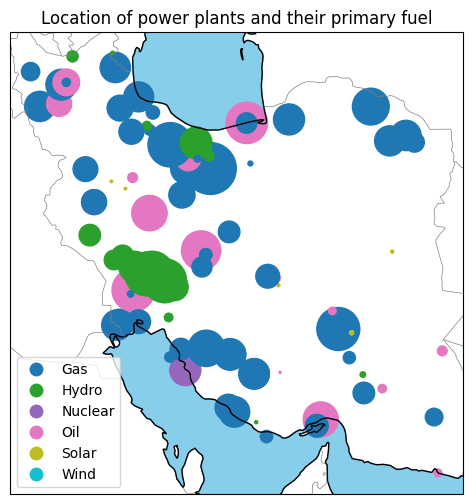

In [13]:
pp = pd.read_csv(url_power_plants)
pp = pp[pp["country"] == "IRN"]

geometry = gpd.points_from_xy(pp.longitude, pp.latitude) # saving geometry from long and lat of the data to create a geopanda

pp_ir = gpd.GeoDataFrame(pp, geometry=geometry, crs="WGS84")

# Plot them
fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes(projection = ccrs.epsg(3857))

pp_ir.to_crs(epsg=3857).plot(
    ax = ax,
    column = "primary_fuel",
    markersize = pp_ir["capacity_mw"]/2, # deviding by 2 for better illustration
    legend=True,
)

ax.coastlines()

ax.add_feature(cartopy.feature.OCEAN, color="skyblue")
ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#ax.add_feature(cartopy.feature.LAKES, color="skyblue")
#ax.set_extent([44, 64, 24, 41], crs=ccrs.PlateCarree())

ax.set_title("Location of power plants and their primary fuel") 

In [14]:
pp

country country_long                 name   gppd_idnr  capacity_mw  \
15819     IRN         Iran          Abadan C.C.  WRI1008113        820.0   
15820     IRN         Iran       Ahwaz (ramiin)  WRI1008114       1903.0   
15821     IRN         Iran  Aliabad Power Plant  WRI1029942       1000.0   
15822     IRN         Iran           Amir Kabir  WRI1008115         90.0   
15823     IRN         Iran           Amir Kabir  WKS0070133          7.0   
...       ...          ...                  ...         ...          ...   
15921     IRN         Iran              Zahedan  WRI1008207        100.0   
15922     IRN         Iran               Zarand  WRI1008208         60.0   
15923     IRN         Iran               Zargan  WRI1008209         43.0   
15924     IRN         Iran              Zobahan  WRI1008211        162.0   
15925     IRN         Iran        Zobahan (gas)  WRI1008212        139.0   

       latitude  longitude primary_fuel other_fuel1 other_fuel2  ...  \
15819   30.4020    48.3580          Gas         NaN         NaN  ...   
15820   31.5027    48.8830          Oil         NaN         NaN  ...   
15821   36.9443    54.8902          Gas         NaN         NaN  ...   
15822   35.9564    51.0890        Hydro         NaN         NaN  ...   
15823   35.0100    48.0300        Solar         NaN         NaN  ...   
...         ...        ...          ...         ...         ...  ...   
15921   29.4770    60.8070          Oil         NaN         NaN  ...   
15922   30.8127    56.5640          Oil         NaN         NaN  ...   
15923   31.3742    48.7731          Gas         NaN         NaN  ...   
15924   32.6572    51.6776          Gas         NaN         NaN  ...   
15925   32.6572    51.6776          Gas         NaN         NaN  ...   

      estimated_generation_gwh_2016  estimated_generation_gwh_2017  \
15819                           NaN                        4355.53   
15820                           NaN                        5245.60   
15821                           NaN                        5311.62   
15822                        144.88                         126.24   
15823                         13.99                          14.09   
...                             ...                            ...   
15921                           NaN                         275.64   
15922                           NaN                         165.38   
15923                           NaN                         228.39   
15924                           NaN                         860.48   
15925                           NaN                         738.31   

      estimated_generation_note_2013 estimated_generation_note_2014  \
15819                  NO-ESTIMATION                  NO-ESTIMATION   
15820                  NO-ESTIMATION                  NO-ESTIMATION   
15821                  NO-ESTIMATION                  NO-ESTIMATION   
15822                       HYDRO-V1                       HYDRO-V1   
15823                SOLAR-V1-NO-AGE                SOLAR-V1-NO-AGE   
...                              ...                            ...   
15921                  NO-ESTIMATION                  NO-ESTIMATION   
15922                  NO-ESTIMATION                  NO-ESTIMATION   
15923                  NO-ESTIMATION                  NO-ESTIMATION   
15924                  NO-ESTIMATION                  NO-ESTIMATION   
15925                  NO-ESTIMATION                  NO-ESTIMATION   

      estimated_generation_note_2015 estimated_generation_note_2016  \
15819                  NO-ESTIMATION                  NO-ESTIMATION   
15820                  NO-ESTIMATION                  NO-ESTIMATION   
15821                  NO-ESTIMATION                  NO-ESTIMATION   
15822                       HYDRO-V1                       HYDRO-V1   
15823                SOLAR-V1-NO-AGE                SOLAR-V1-NO-AGE   
...                              ...                            ...   
15921                  NO-ESTIMATION 

### Copernicus GLC

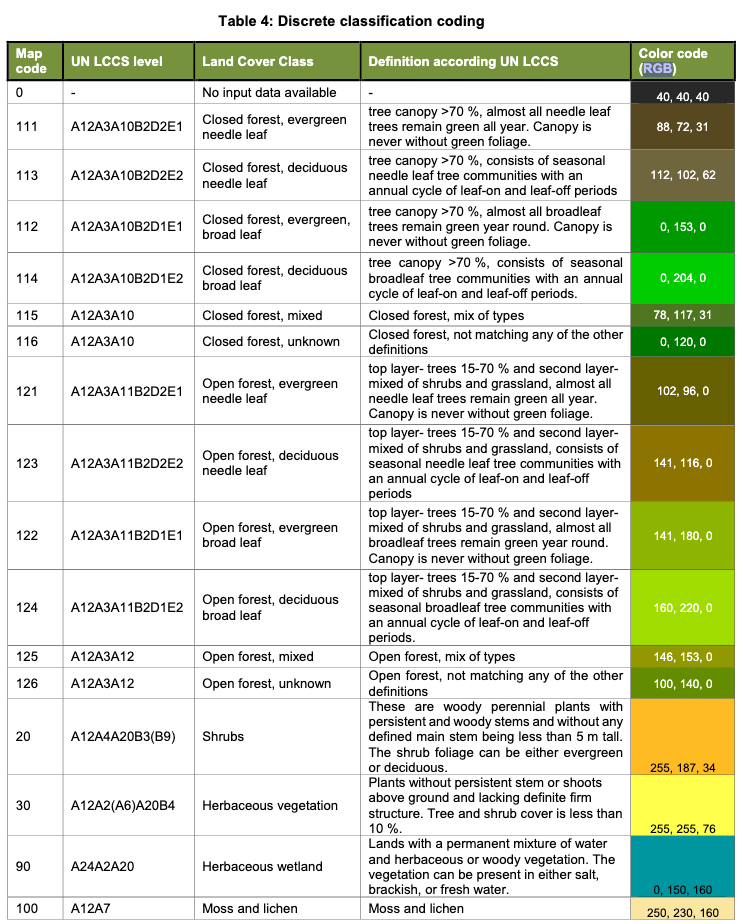
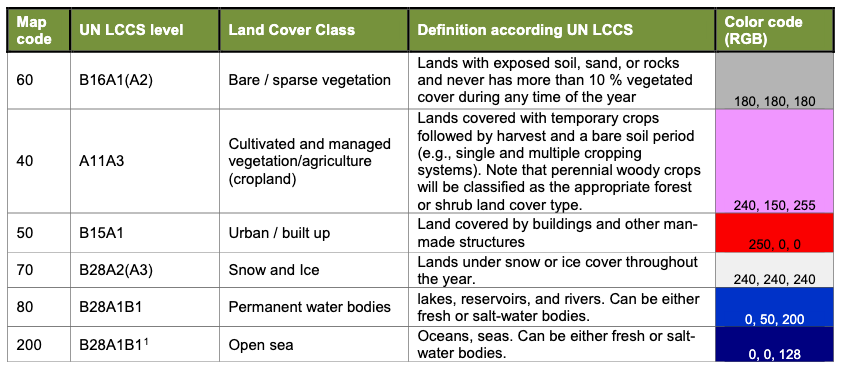

in these two tables above, the classification is documented

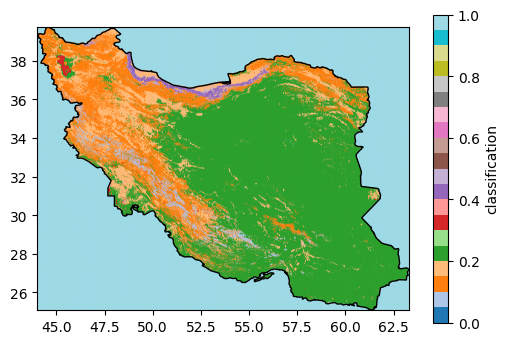

In [15]:
glc_ir = rio.open(url_glc_local)
band_glc = glc_ir.read(1)
glc_ir.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [16]:
"""
# world's protected areas
glc_ir = rio.open(url_glc_local)
band_glc = glc_ir.read(1)

fig, ax = plt.subplots(figsize=(6, 8))

shape_ir.to_crs(4326).boundary.plot(ax=ax, color="black", linewidth=1)

show(band_glc, transform=glc_ir.transform, cmap="tab20", ax=ax)

plt.colorbar(ax.images[0], ax=ax, label="classification", shrink=0.5)
## Classification noch genauer beschreiben und labeln
"""

'\n# world\'s protected areas\nglc_ir = rio.open(url_glc_local)\nband_glc = glc_ir.read(1)\n\nfig, ax = plt.subplots(figsize=(6, 8))\n\nshape_ir.to_crs(4326).boundary.plot(ax=ax, color="black", linewidth=1)\n\nshow(band_glc, transform=glc_ir.transform, cmap="tab20", ax=ax)\n\nplt.colorbar(ax.images[0], ax=ax, label="classification", shrink=0.5)\n## Classification noch genauer beschreiben und labeln\n'

### Costs (remember to select the year from 2020 to 2050)

In [17]:
# you can adjust the year, you want the cost to be projected to from 2020 to 2050 (at the beginning in COST_YEAR variable)
costs = pd.read_csv(url_costs)
costs # now for 2025

technology          parameter      value  \
0     Alkaline electrolyzer large size                FOM     4.6000   
1     Alkaline electrolyzer large size                VOM     0.2389   
2     Alkaline electrolyzer large size  electricity-input     1.3800   
3     Alkaline electrolyzer large size         investment   429.0306   
4     Alkaline electrolyzer large size           lifetime    40.0000   
...                                ...                ...        ...   
1234                      waste CHP CC    efficiency-heat     0.7627   
1235                      waste CHP CC         investment  8829.8509   
1236                      waste CHP CC           lifetime    25.0000   
1237                water tank charger         efficiency     0.9000   
1238             water tank discharger         efficiency     0.9000   

               unit                                             source  \
0            %/year  JRC, 01_JRC-EU-TIMES Full model, https://zenod...   
1        EUR/MWh_H2  JRC, 01_JRC-EU-TIMES Full model, https://zenod...   
2     MWh_el/MWh_H2  JRC, 01_JRC-EU-TIMES Full model, https://zenod...   
3            EUR/kW  JRC, 01_JRC-EU-TIMES Full model, https://zenod...   
4             years  JRC, 01_JRC-EU-TIMES Full model, https://zenod...   
...             ...                                                ...   
1234       per unit  Danish Energy Agency, inputs/technology_data_f...   
1235       EUR/kW_e  Danish Energy Agency, inputs/technology_data_f...   
1236          years  Danish Energy Agency, inputs/technology_data_f...   
1237       per unit                                                 HP   
1238       per unit                                                 HP   

                                    further description  currency_year  
0                              Reference capacity 72 MW         2010.0  
1                              Reference capacity 72 MW         2010.0  
2                              Reference capacity 72 MW            NaN  
3                              Reference capacity 72 MW         2010.0  
4                              Reference capacity 72 MW            NaN  
...                                                 ...            ...  
1234  08 WtE CHP, Large, 50 degree:  Heat efficiency...         2015.0  
1235  08 WtE CHP, Large, 50 degree:  Nominal investm...         2015.0  
1236  08 WtE CHP, Large, 50 degree:  Technical lifetime         2015.0  
1237                    from old pypsa cost assumptions         2015.0  
1238                    from old pypsa cost assumptions         2015.0  

[1239 rows x 7 columns]

## Land Eligibility Analysis

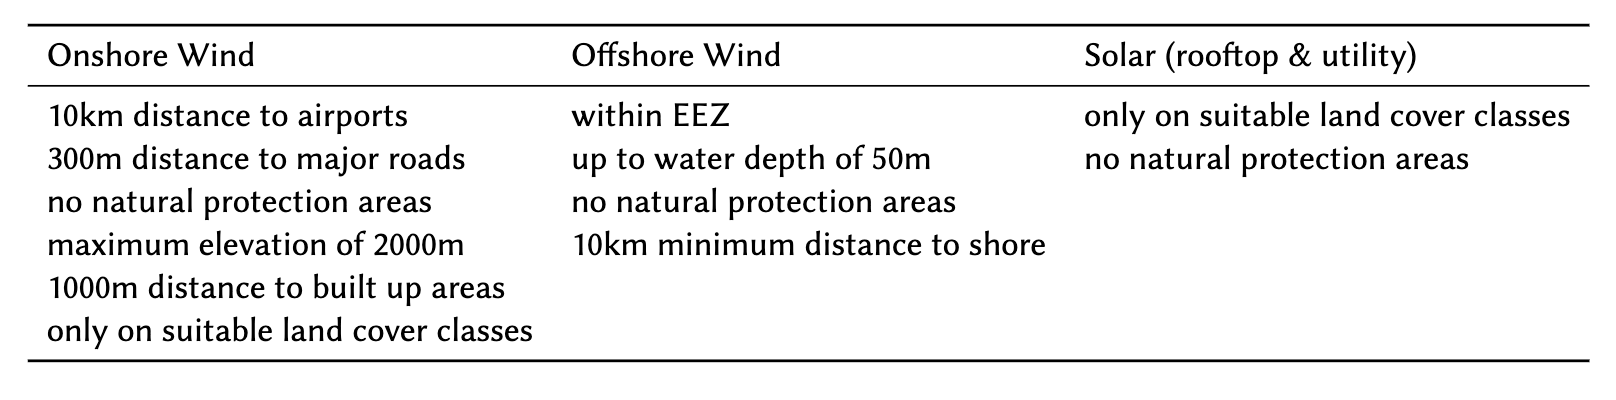

### Wind on-shore

#### Airports

In [18]:
excluder_wind_on = ExclusionContainer(crs=3857, res=100)

# roads and airports are .gpkg files
excluder_wind_on.add_geometry(url_airports, buffer=10000)

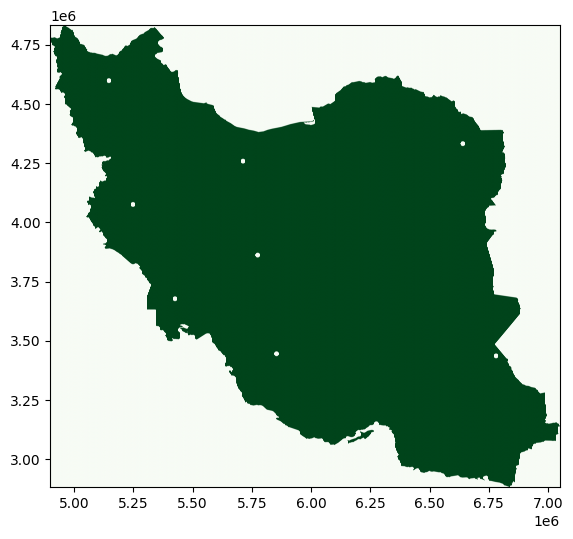

In [19]:
"""
band, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Greens", transform=transform)"""

'\nband, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Greens", transform=transform)'

#### Roads

In [20]:
excluder_wind_on.add_geometry(url_roads, buffer=300)

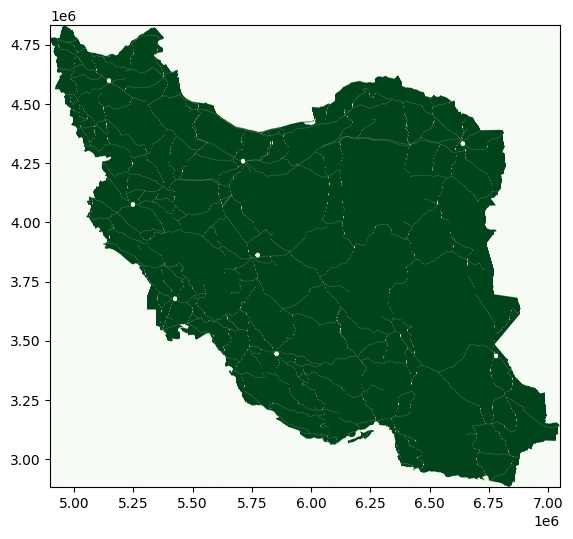

In [21]:
"""
band, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Greens", transform=transform)"""

'\nband, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Greens", transform=transform)'

#### WDPA: World Protected Areas

In [22]:
# wpda: world protected area
excluder_wind_on.add_raster(url_wdpa_local)

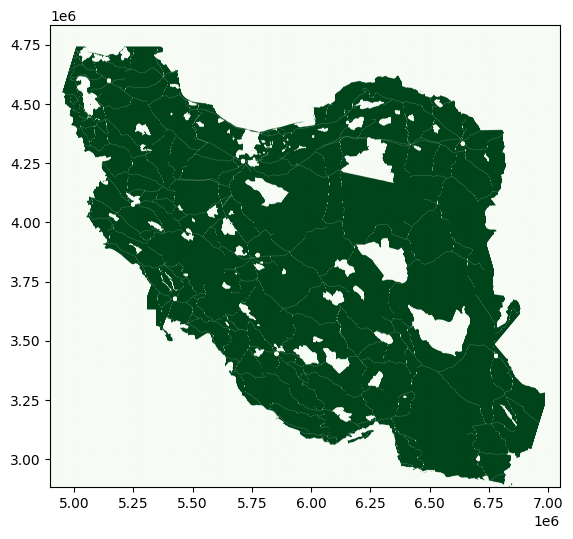

In [23]:
"""
band, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Greens", transform=transform)"""

'\nband, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Greens", transform=transform)'

#### Elevation below 2000 meters

In [24]:
excluder_wind_on.add_raster(
    url_gebco_local,
    crs=4326,        # specify raster's original CRS
    invert=True,     # include only these values
    codes=lambda val: val <= 2000
)

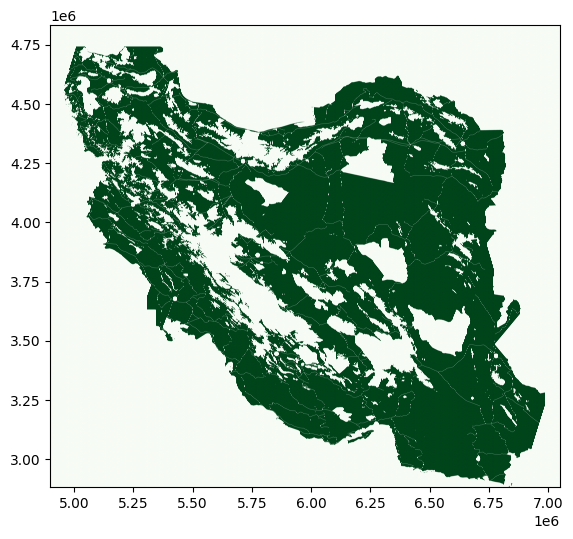

In [25]:
"""band, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Greens", transform=transform)"""

'band, transform = shape_availability(shape_ir.to_crs(3857), excluder_wind_on)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Greens", transform=transform)'

#### 1000 meters distance to built up areas (GLC code 50)

In [26]:
excluder_wind_on.add_raster(url_glc_local, codes=[50], buffer=1000, crs=glc_ir.crs, nodata=0)

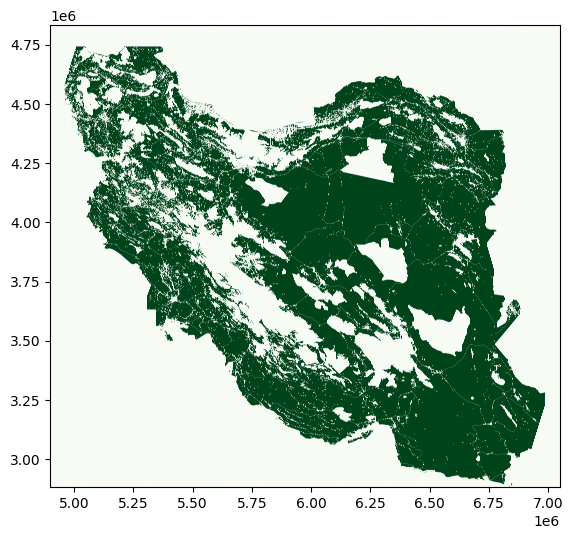

In [27]:
"""band, transform = shape_availability(shape_ir.to_crs(excluder_wind_on.crs), excluder_wind_on)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Greens", transform=transform)"""

'band, transform = shape_availability(shape_ir.to_crs(excluder_wind_on.crs), excluder_wind_on)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Greens", transform=transform)'

#### only on suitable land cover classes (GLC)

In [28]:
# codes 60: Bare / sparse vegetation, 20: Shrubs, 30: Herbaceous vegetation
excluder_wind_on.add_raster(url_glc_local, codes = [20, 30, 60], invert = True, crs=glc_ir.crs, nodata=0)

# codes 100: Moss & Lichen, 90: Wetlands, 200: Open sea, 80: water bodies, 70: snow & ice, 111, 112, 113, 114, 115, 116: closed forrest
excluder_wind_on.add_raster(url_glc_local, codes = [70, 80, 90, 100, 111, 112, 113, 114, 115, 116, 200], crs=glc_ir.crs, nodata=0)

# open forests (121 - 126) and cropland (40) are arguable!!

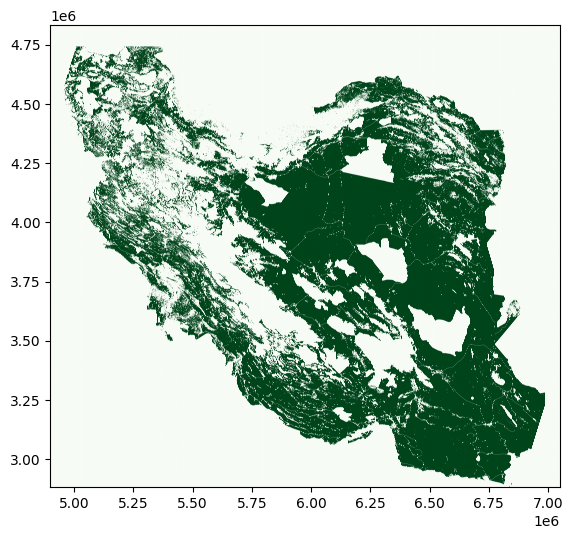

In [29]:
"""band, transform = shape_availability(shape_ir.to_crs(excluder_wind_on.crs), excluder_wind_on)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Greens", transform=transform)"""

'band, transform = shape_availability(shape_ir.to_crs(excluder_wind_on.crs), excluder_wind_on)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Greens", transform=transform)'

### Solar PV

#### World protected areas (WDPA)

In [30]:
excluder_pv = ExclusionContainer(crs=3857, res=100)

# wpda: world protected area
excluder_pv.add_raster(url_wdpa_local)

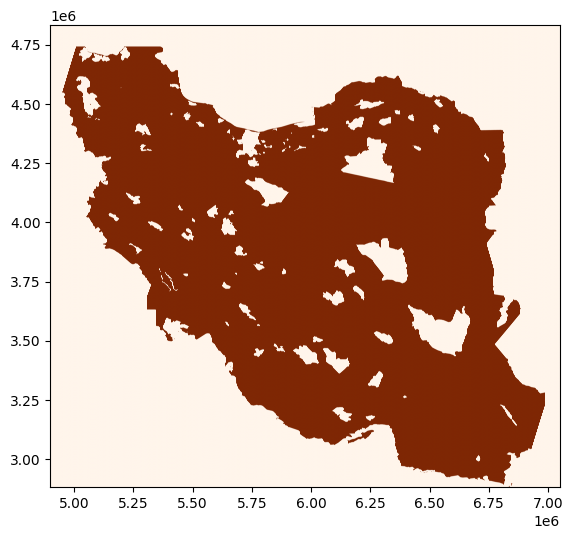

In [31]:
"""band, transform = shape_availability(shape_ir.to_crs(excluder_pv.crs), excluder_pv)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Oranges", transform=transform)"""

'band, transform = shape_availability(shape_ir.to_crs(excluder_pv.crs), excluder_pv)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Oranges", transform=transform)'

#### only on suitable land cover classes

In [32]:
# EXCLUDE: codes 100: Moss & Lichen, 90: Wetlands, 200: Open sea, 80: water bodies, 70: snow & ice, 111, 112, 113, 114, 115, 116: closed forrest
excluder_pv.add_raster(url_glc_local, codes = [70, 80, 90, 100, 111, 112, 113, 114, 115, 116, 200], crs=glc_ir.crs, nodata=0)

# INCLUDE: rooftop in Built up areas (50), and utility in Shrubs (20), Herbaceous vegetation (30), Bare / sparse vegetation (60)
excluder_pv.add_raster(url_glc_local, codes = [20, 30, 50, 60], invert = True, crs=glc_ir.crs, nodata=0)

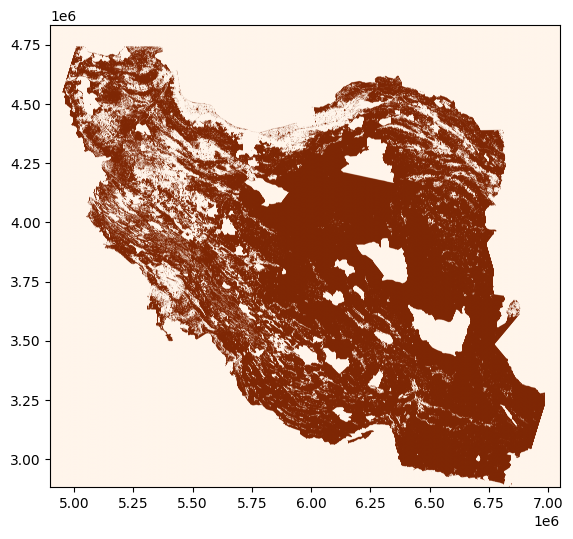

In [33]:
"""band, transform = shape_availability(shape_ir.to_crs(excluder_pv.crs), excluder_pv)

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes()

shape_ir.plot(ax=ax, color="none")
show(band, ax=ax, cmap="Oranges", transform=transform)"""

'band, transform = shape_availability(shape_ir.to_crs(excluder_pv.crs), excluder_pv)\n\nfig = plt.figure(figsize=(10, 6)) \nax = plt.axes()\n\nshape_ir.plot(ax=ax, color="none")\nshow(band, ax=ax, cmap="Oranges", transform=transform)'

### Wind off-shore

#### 10 km distance to shore

In [34]:
excluder_wind_off = ExclusionContainer(crs=3857, res=100)

# exluding the land and ensuring a minimum of 10 km from shore distance
excluder_wind_off.add_geometry(shape_ir.to_crs(excluder_wind_off.crs), buffer=10000) 

In [35]:
"""band, transform = shape_availability(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)

fig = plt.figure(figsize=(20, 12)) 
ax = plt.axes(projection = ccrs.epsg(3857))

shape_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)
eez_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)

#ax.set_extent([44, 64, 22, 41], crs=ccrs.PlateCarree())

show(band, ax=ax, cmap="Blues", transform=transform)"""

'band, transform = shape_availability(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)\n\nfig = plt.figure(figsize=(20, 12)) \nax = plt.axes(projection = ccrs.epsg(3857))\n\nshape_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)\neez_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)\n\n#ax.set_extent([44, 64, 22, 41], crs=ccrs.PlateCarree())\n\nshow(band, ax=ax, cmap="Blues", transform=transform)'

#### WDPA World protected areas

In [36]:
# wpda: world protected area
excluder_wind_off.add_raster(url_wdpa_local)

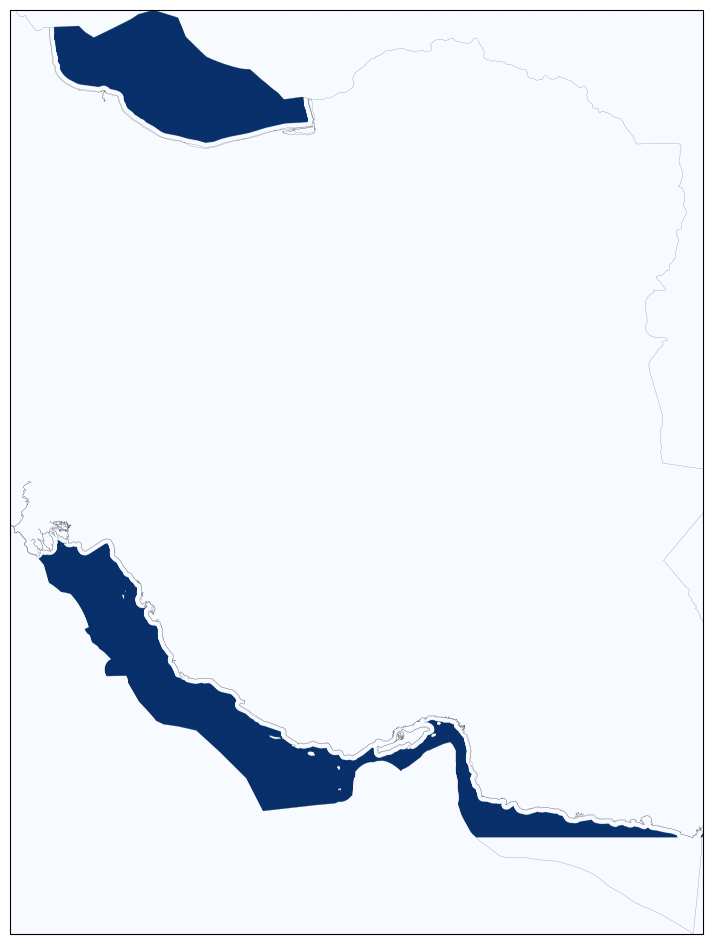

In [37]:
"""band, transform = shape_availability(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)

fig = plt.figure(figsize=(20, 12)) 
ax = plt.axes(projection = ccrs.epsg(3857))

shape_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)
eez_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)

#ax.set_extent([44, 64, 22, 41], crs=ccrs.PlateCarree())

show(band, ax=ax, cmap="Blues", transform=transform)"""

'band, transform = shape_availability(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)\n\nfig = plt.figure(figsize=(20, 12)) \nax = plt.axes(projection = ccrs.epsg(3857))\n\nshape_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)\neez_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)\n\n#ax.set_extent([44, 64, 22, 41], crs=ccrs.PlateCarree())\n\nshow(band, ax=ax, cmap="Blues", transform=transform)'

#### water depth up to 50 meters

In [38]:
# water depth of less than 50 meters
excluder_wind_off.add_raster(
    url_gebco_tif_local,
    #crs=4326,
    #codes=lambda z: np.isfinite(z) & (z > 50)
    codes=lambda z: (z <= -50)

    #codes=lambda z: np.isfinite(z) # no elligible values anymore --> all values are definite
    #codes=lambda z: np.isfinite(z) & (z < 0) # same as before --> everything is positive in the sea (no negative values here)
    #codes=lambda z: np.isfinite(z) & ((z > 0) | (z < -50)) # no elligible values anymore --> all values are positive
    #codes=lambda z: False
)

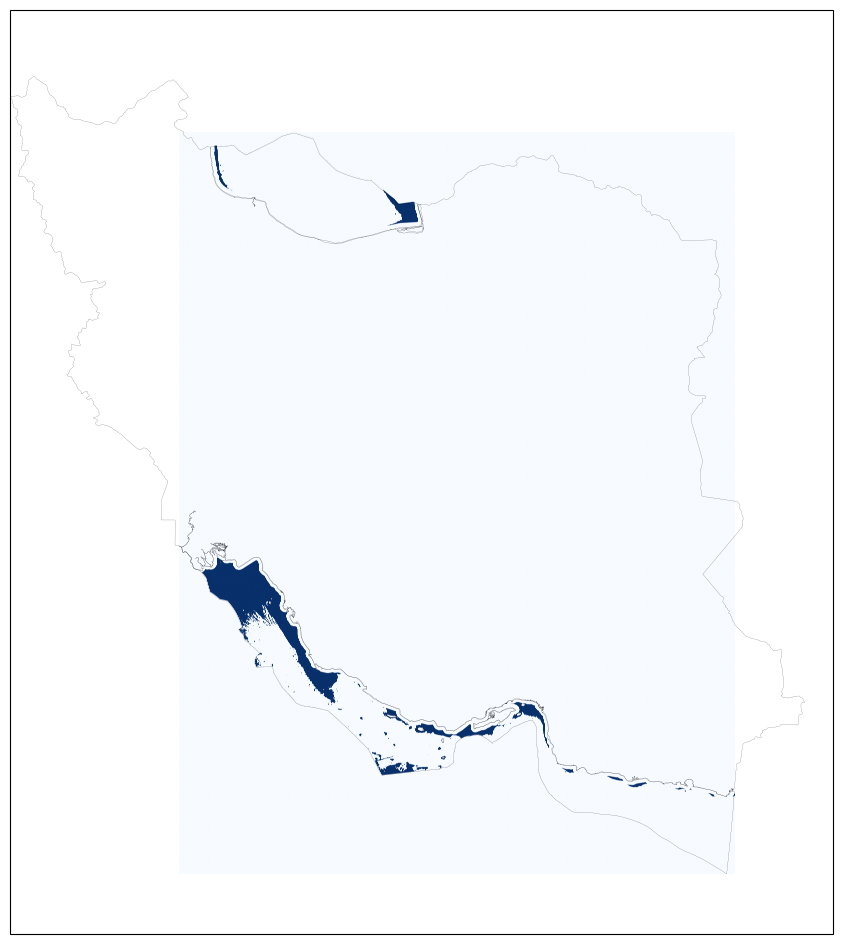

In [39]:
"""band, transform = shape_availability(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)

fig = plt.figure(figsize=(20, 12)) 
ax = plt.axes(projection = ccrs.epsg(3857))

shape_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)
eez_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)

ax.set_extent([44, 64, 22, 41], crs=ccrs.PlateCarree())

show(band, ax=ax, cmap="Blues", transform=transform)"""

'band, transform = shape_availability(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)\n\nfig = plt.figure(figsize=(20, 12)) \nax = plt.axes(projection = ccrs.epsg(3857))\n\nshape_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)\neez_ir.to_crs(excluder_wind_off.crs).boundary.plot(ax=ax, color="black", linewidth=0.1)\n\nax.set_extent([44, 64, 22, 41], crs=ccrs.PlateCarree())\n\nshow(band, ax=ax, cmap="Blues", transform=transform)'

## Preparing Weather Data ERA5

first going through "Tutorial era5 weather data.ipynb" to create the "era5-2025-IR.nc" file. Then import it here as a cutout

era5 Data for Iran for 2025 can be downloaded using the google drive link: 

https://drive.google.com/file/d/1Ll5WF6_14_cJXLBFo84EOSpNsG6yiQY2/view?usp=drive_link

after downloading it into your workspace, you can create the cutout using the code below :)

In [40]:
#cutout = atlite.Cutout("era5-2025-IR.nc")

In [41]:
#cutout

In [42]:
#cutout.data

In [43]:
"""ax = shape_ir.to_crs(4326).plot()
cutout.grid.plot(ax=ax, edgecolor="grey", color="None");"""

'ax = shape_ir.to_crs(4326).plot()\ncutout.grid.plot(ax=ax, edgecolor="grey", color="None");'

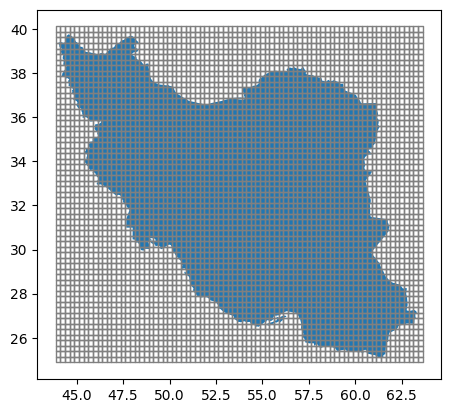

In [44]:
#cutout.data.mean(dim=["x", "y"]).influx_direct.plot();

DEFINED CAPACITY DENSITY OF 3 MW/km2

In [45]:
"""cap_per_sqkm = 3  # 3 MW/km^2
area = cutout.grid.set_index(["y", "x"]).to_crs(AREA_CRS).area / 1e6  # in km^2
area = xr.DataArray(area, dims=("spatial"))"""

'cap_per_sqkm = 3  # 3 MW/km^2\narea = cutout.grid.set_index(["y", "x"]).to_crs(AREA_CRS).area / 1e6  # in km^2\narea = xr.DataArray(area, dims=("spatial"))'

### Wind

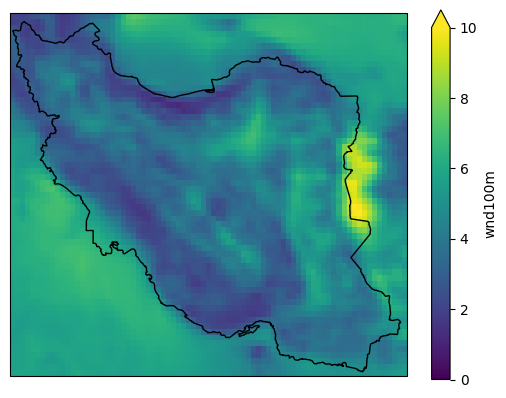

In [46]:
"""wnd100m = cutout.data.wnd100m.mean(dim="time")

ax = plt.axes(projection=ccrs.PlateCarree())

wnd100m.plot(ax=ax, vmin=0, vmax=10)

shape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none");"""

'wnd100m = cutout.data.wnd100m.mean(dim="time")\n\nax = plt.axes(projection=ccrs.PlateCarree())\n\nwnd100m.plot(ax=ax, vmin=0, vmax=10)\n\nshape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none");'

Using roughness, We can scale the 100 meter wind speeds down to 10 meters using the **log law**:

$$\frac{U(z)}{U(z_r)} = \frac{\ln\left(\frac{z}{z_0}\right)}{\ln\left(\frac{z_r}{z_0}\right)}$$

In [47]:
"""z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m
wnd10m = wnd100m * np.log(10 / z_r) / np.log(100 / z_r)

ax = plt.axes(projection=ccrs.PlateCarree())

wnd10m.mean(dim="time").plot(ax=ax, vmin=0, vmax=10)

shape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none");"""

'z_r = cutout.data.roughness\nwnd100m = cutout.data.wnd100m\nwnd10m = wnd100m * np.log(10 / z_r) / np.log(100 / z_r)\n\nax = plt.axes(projection=ccrs.PlateCarree())\n\nwnd10m.mean(dim="time").plot(ax=ax, vmin=0, vmax=10)\n\nshape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none");'

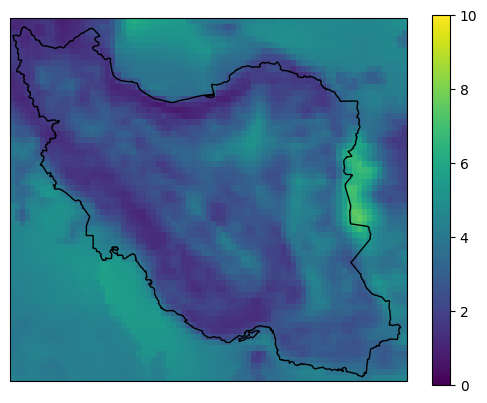

#### Wind On Shore

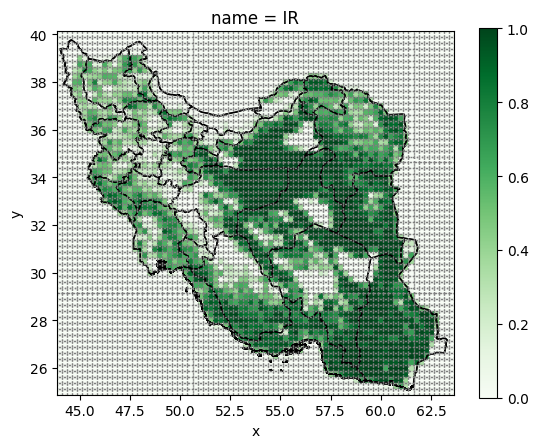

In [48]:
"""# a list to collect all the pv capacities for each region
wind_onshore_capacity_per_region = [] # in MW

for i in range(len(gadm_ir)):
    A_wind_on_i = cutout.availabilitymatrix(gadm_ir.geometry.iloc[i:i + 1], excluder_wind_on) # only the i_th state in the country
    
    # based on that, creating the capacity matrix
    capacity_matrix_wind_on = A_wind_on_i.stack(spatial=["y", "x"]) * area * cap_per_sqkm 

    # then calculating the generation capacity time series for the state (i. e. Albroz)
    wind = cutout.wind(matrix=capacity_matrix_wind_on, turbine="Vestas_V112_3MW", index=gadm_ir.geometry.iloc[i:i + 1].index).squeeze()

    wind_onshore_capacity_per_region.append(wind.to_series()) # in MW

# giving the name for each state
for state in range(len(wind_onshore_capacity_per_region)):
    wind_onshore_capacity_per_region[state].name = f"wind onshore generation {gadm_ir.NAME_1[state]}" 

# creating a pandas DataFrame and saving the data
wind_on_df = pd.concat(wind_onshore_capacity_per_region, axis=1)
wind_on_df.to_csv("data/wind_on_capacity_per_region_timeseries.csv")"""

'# a list to collect all the pv capacities for each region\nwind_onshore_capacity_per_region = [] # in MW\n\nfor i in range(len(gadm_ir)):\n    A_wind_on_i = cutout.availabilitymatrix(gadm_ir.geometry.iloc[i:i + 1], excluder_wind_on) # only the i_th state in the country\n\n    # based on that, creating the capacity matrix\n    capacity_matrix_wind_on = A_wind_on_i.stack(spatial=["y", "x"]) * area * cap_per_sqkm \n\n    # then calculating the generation capacity time series for the state (i. e. Albroz)\n    wind = cutout.wind(matrix=capacity_matrix_wind_on, turbine="Vestas_V112_3MW", index=gadm_ir.geometry.iloc[i:i + 1].index).squeeze()\n\n    wind_onshore_capacity_per_region.append(wind.to_series()) # in MW\n\n# giving the name for each state\nfor state in range(len(wind_onshore_capacity_per_region)):\n    wind_onshore_capacity_per_region[state].name = f"wind onshore generation {gadm_ir.NAME_1[state]}" \n\n# creating a pandas DataFrame and saving the data\nwind_on_df = pd.concat(wind_o

In [49]:
wind_on_capacity_per_region = pd.read_csv("data/wind_on_capacity_per_region_timeseries.csv", index_col=0, parse_dates=True)
wind_on_capacity_per_region # in MW

wind onshore generation Alborz  \
time                                                  
2025-01-01 00:00:00                      196.127187   
2025-01-01 01:00:00                      225.852831   
2025-01-01 02:00:00                      195.619768   
2025-01-01 03:00:00                      176.703852   
2025-01-01 04:00:00                      166.314698   
...                                             ...   
2025-12-31 19:00:00                      253.477032   
2025-12-31 20:00:00                      197.488698   
2025-12-31 21:00:00                      180.041125   
2025-12-31 22:00:00                      277.891533   
2025-12-31 23:00:00                      273.247744   

                     wind onshore generation Ardebil  \
time                                                   
2025-01-01 00:00:00                        30.120745   
2025-01-01 01:00:00                        27.643348   
2025-01-01 02:00:00                        19.773997   
2025-01-01 03:00:00                        22.474204   
2025-01-01 04:00:00                        30.480681   
...                                              ...   
2025-12-31 19:00:00                      7400.361376   
2025-12-31 20:00:00                      7098.896615   
2025-12-31 21:00:00                      7153.481356   
2025-12-31 22:00:00                      7337.765050   
2025-12-31 23:00:00                      6972.195483   

                     wind onshore generation Bushehr  \
time                                                   
2025-01-01 00:00:00                      5970.985755   
2025-01-01 01:00:00                      6605.407047   
2025-01-01 02:00:00                      6402.248392   
2025-01-01 03:00:00                      5609.515928   
2025-01-01 04:00:00                      4708.166017   
...                                              ...   
2025-12-31 19:00:00                       302.954659   
2025-12-31 20:00:00                       308.525436   
2025-12-31 21:00:00                       249.014536   
2025-12-31 22:00:00                        86.557143   
2025-12-31 23:00:00                        84.583557   

                     wind onshore generation Chahar Mahall and Bakhtiari  \
time                                                                       
2025-01-01 00:00:00                                           0.000000     
2025-01-01 01:00:00                                           0.000000     
2025-01-01 02:00:00                                           0.000000     
2025-01-01 03:00:00                                           0.004600     
2025-01-01 04:00:00                                           0.088833     
...                                                                ...     
2025-12-31 19:00:00                                           4.224622     
2025-12-31 20:00:00                                           5.464600     
2025-12-31 21:00:00                                           6.280537     
2025-12-31 22:00:00                                           4.884655     
2025-12-31 23:00:00                                           5.150265     

                     wind onshore generation East Azarbaijan  \
time                                                           
2025-01-01 00:00:00                               435.435878   
2025-01-01 01:00:00                               467.018477   
2025-01-01 02:00:00                               523.478899   
2025-01-01 03:00:00                               565.984037   
2025-01-01 04:00:00                               664.866326   
...                                                      ...   
2025-12-31 19:00:00                             20070.617979   
2025-12-31 20:00:00                             19360.931525   
2025-12-31 21:00:00                             18275.884709   
2025-12-31 22:00:00                             18853.126848   
2025-12-31 23:00:00                             19282.964341   

                     wind

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_90260/1165178903.py:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



<Axes: title={'center': 'Wind Onshore Capacity Potential for weather year 2025'}, xlabel='Region in Iran', ylabel='Average Yearly Capacity (GW)'>

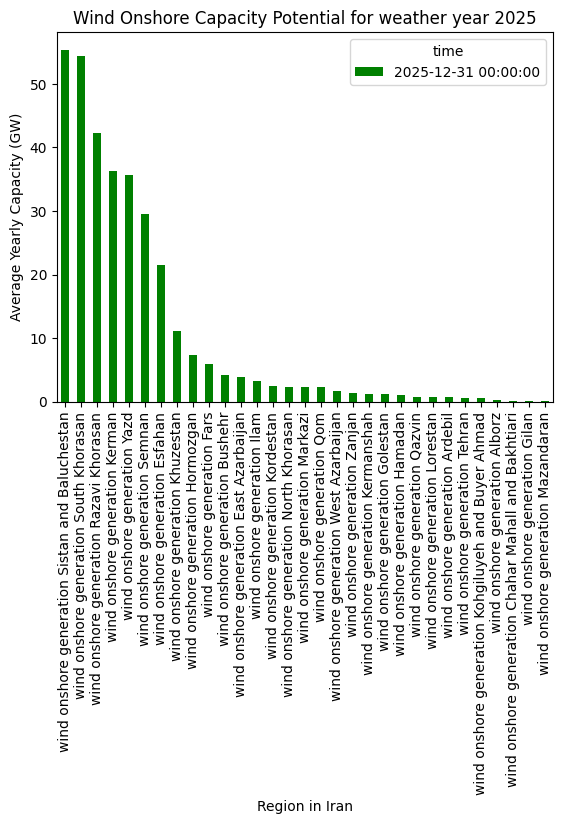

In [50]:
wind_on_capacity_per_region.resample("Y").mean().divide(1e3).T.sort_values(by="2025-12-31", ascending=False).plot(
    kind="bar",
    color="Green",
    xlabel="Region in Iran",
    ylabel="Average Yearly Capacity (GW)",
    title="Wind Onshore Capacity Potential for weather year 2025"
)

In [51]:
#A_wind_on = cutout.availabilitymatrix(shape_ir, excluder_wind_on)

In [52]:
"""fig, ax = plt.subplots()
A_wind_on.sel(name="IR").plot(cmap="Greens")
gadm_ir.geometry.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
shape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");"""

'fig, ax = plt.subplots()\nA_wind_on.sel(name="IR").plot(cmap="Greens")\ngadm_ir.geometry.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\nshape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\ncutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");'

#### Wind Off Shore

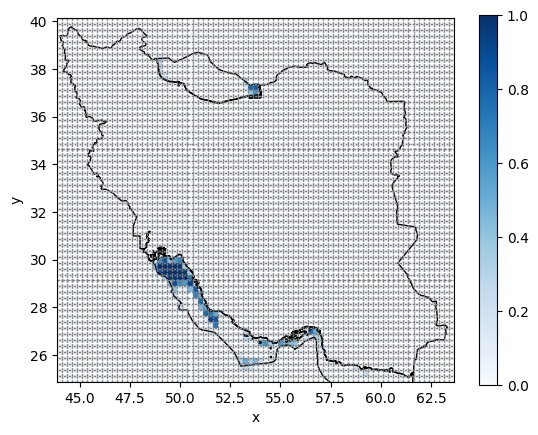

In [53]:
"""wind_offshore_capacity_per_region = [] # in MW

for i in range(len(eez_ir)):
    A_wind_off_i = cutout.availabilitymatrix(eez_ir.geometry.iloc[i:i + 1], excluder_wind_off) # one for each eez area
    
    # based on that, creating the capacity matrix
    capacity_matrix_wind_off = A_wind_off_i.stack(spatial=["y", "x"]) * area * cap_per_sqkm 

    # then calculating the generation capacity time series for the area
    wind = cutout.wind(matrix=capacity_matrix_wind_off, turbine="NREL_ReferenceTurbine_5MW_offshore", index=eez_ir.geometry.iloc[i:i + 1].index).squeeze()

    wind_offshore_capacity_per_region.append(wind.to_series()) # in MW

wind_offshore_capacity_per_region[0].name = "wind_offshore generation Persian Gulf"
wind_offshore_capacity_per_region[1].name = "wind_offshore generation Caspian Sea"

# creating a pandas DataFrame and saving the data
wind_off_df = pd.concat(wind_offshore_capacity_per_region, axis=1)
wind_off_df.to_csv("data/wind_off_capacity_per_region_timeseries.csv")"""

'wind_offshore_capacity_per_region = [] # in MW\n\nfor i in range(len(eez_ir)):\n    A_wind_off_i = cutout.availabilitymatrix(eez_ir.geometry.iloc[i:i + 1], excluder_wind_off) # one for each eez area\n\n    # based on that, creating the capacity matrix\n    capacity_matrix_wind_off = A_wind_off_i.stack(spatial=["y", "x"]) * area * cap_per_sqkm \n\n    # then calculating the generation capacity time series for the area\n    wind = cutout.wind(matrix=capacity_matrix_wind_off, turbine="NREL_ReferenceTurbine_5MW_offshore", index=eez_ir.geometry.iloc[i:i + 1].index).squeeze()\n\n    wind_offshore_capacity_per_region.append(wind.to_series()) # in MW\n\nwind_offshore_capacity_per_region[0].name = "wind_offshore generation Persian Gulf"\nwind_offshore_capacity_per_region[1].name = "wind_offshore generation Caspian Sea"\n\n# creating a pandas DataFrame and saving the data\nwind_off_df = pd.concat(wind_offshore_capacity_per_region, axis=1)\nwind_off_df.to_csv("data/wind_off_capacity_per_region_t

In [54]:
wind_off_capacity_per_region = pd.read_csv("data/wind_off_capacity_per_region_timeseries.csv", index_col=0, parse_dates=True)
#wind_off_df.resample("M").mean().plot()
wind_off_capacity_per_region

wind_offshore generation Persian Gulf  \
time                                                         
2025-01-01 00:00:00                           49193.476756   
2025-01-01 01:00:00                           49770.698946   
2025-01-01 02:00:00                           48660.525258   
2025-01-01 03:00:00                           47112.196698   
2025-01-01 04:00:00                           45146.608566   
...                                                    ...   
2025-12-31 19:00:00                            4770.974840   
2025-12-31 20:00:00                            4225.594383   
2025-12-31 21:00:00                            3783.745942   
2025-12-31 22:00:00                            2124.373404   
2025-12-31 23:00:00                            2108.814652   

                     wind_offshore generation Caspian Sea  
time                                                       
2025-01-01 00:00:00                            137.568933  
2025-01-01 01:00:00                            121.983738  
2025-01-01 02:00:00                            101.953269  
2025-01-01 03:00:00                             59.974893  
2025-01-01 04:00:00                             10.575785  
...                                                   ...  
2025-12-31 19:00:00                            566.847067  
2025-12-31 20:00:00                            460.142692  
2025-12-31 21:00:00                            286.239636  
2025-12-31 22:00:00                            407.842181  
2025-12-31 23:00:00                            549.868929  

[8760 rows x 2 columns]

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_90260/3384508863.py:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



<Axes: title={'center': 'Wind Offshore Capacity Potential for weather year 2025'}, xlabel='Region in Iran', ylabel='Average Yearly Capacity (GW)'>

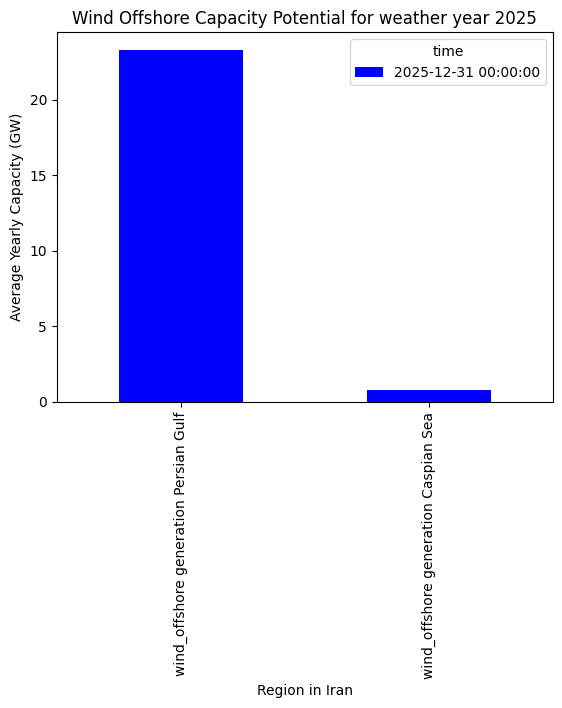

In [55]:
wind_off_capacity_per_region.resample("Y").mean().divide(1e3).T.sort_values(by="2025-12-31", ascending=False).plot(
    kind="bar",
    color="Blue",
    xlabel="Region in Iran",
    ylabel="Average Yearly Capacity (GW)",
    title="Wind Offshore Capacity Potential for weather year 2025"
)

In [56]:
#A_wind_off = cutout.availabilitymatrix(eez_ir.to_crs(excluder_wind_off.crs).geometry, excluder_wind_off)

In [57]:
#A_wind_off.coords

In [58]:
"""fig, ax = plt.subplots()
A_wind_off.sel(dim_0=[0, 1]).sum(dim="dim_0").plot(cmap="Blues")
shape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
eez_ir.to_crs(4326).geometry.plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");"""

'fig, ax = plt.subplots()\nA_wind_off.sel(dim_0=[0, 1]).sum(dim="dim_0").plot(cmap="Blues")\nshape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\neez_ir.to_crs(4326).geometry.plot(ax=ax, edgecolor="k", color="none")\ncutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");'

### PV

In [59]:
"""A_pv = cutout.availabilitymatrix(shape_ir, excluder_pv)
A_pv.coords"""

'A_pv = cutout.availabilitymatrix(shape_ir, excluder_pv)\nA_pv.coords'

In [60]:
"""fig, ax = plt.subplots()
A_pv.sel(name="IR").plot(cmap="Oranges")
gadm_ir.geometry.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
shape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");"""

'fig, ax = plt.subplots()\nA_pv.sel(name="IR").plot(cmap="Oranges")\ngadm_ir.geometry.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\nshape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\ncutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");'

In [61]:
#A_pv_regs = cutout.availabilitymatrix(gadm_ir.geometry, excluder_pv)

In [62]:
#A_pv_regs.coords

In [63]:
"""fig, ax = plt.subplots()
# access and plot only one state
#A_pv_regs.sel(dim_0=2).plot(cmap="Oranges")

# plot every state of the country
A_pv_regs.sel(dim_0=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]).sum(dim="dim_0").plot(cmap="Oranges")
gadm_ir.geometry.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
shape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");"""

'fig, ax = plt.subplots()\n# access and plot only one state\n#A_pv_regs.sel(dim_0=2).plot(cmap="Oranges")\n\n# plot every state of the country\nA_pv_regs.sel(dim_0=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]).sum(dim="dim_0").plot(cmap="Oranges")\ngadm_ir.geometry.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\nshape_ir.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")\ncutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":");'

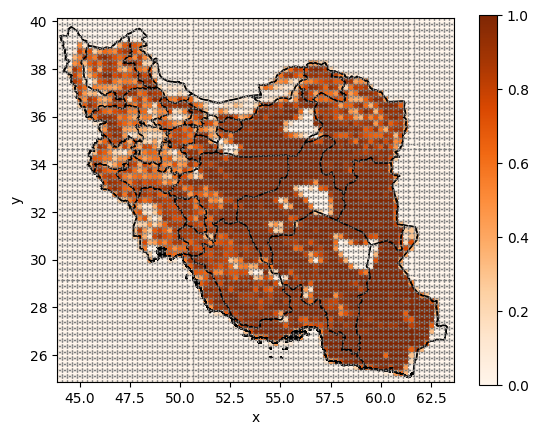

calculating the pv capacity for each region and save it into a list

In [64]:
"""# a list to collect all the pv capacities for each region
pv_capacity_per_region = [] # in MW

for i in range(len(gadm_ir)):
    A_pv_i = cutout.availabilitymatrix(gadm_ir.geometry.iloc[i:i + 1], excluder_pv) # only the i_th state in the country
    
    # based on that, creating the capacity matrix
    capacity_matrix_pv = A_pv_i.stack(spatial=["y", "x"]) * area * cap_per_sqkm 

    # then calculating the generation capacity time series for the state (i. e. Albroz)
    pv = cutout.pv(
        panel="CdTe",
        orientation={"slope": 30.0, "azimuth": 180.0},
        matrix=capacity_matrix_pv,
        index=gadm_ir.geometry.iloc[i:i + 1].index,
    ).squeeze()

    pv_capacity_per_region.append(pv.to_series()) # in MW

# giving the name for each state
for state in range(len(pv_capacity_per_region)):
    pv_capacity_per_region[state].name = f"pv generation {gadm_ir.NAME_1[state]}" 

# creating a pandas DataFrame and saving the data
pv_df = pd.concat(pv_capacity_per_region, axis=1)
pv_df.to_csv("data/pv_capacity_per_region_timeseries.csv")"""

'# a list to collect all the pv capacities for each region\npv_capacity_per_region = [] # in MW\n\nfor i in range(len(gadm_ir)):\n    A_pv_i = cutout.availabilitymatrix(gadm_ir.geometry.iloc[i:i + 1], excluder_pv) # only the i_th state in the country\n\n    # based on that, creating the capacity matrix\n    capacity_matrix_pv = A_pv_i.stack(spatial=["y", "x"]) * area * cap_per_sqkm \n\n    # then calculating the generation capacity time series for the state (i. e. Albroz)\n    pv = cutout.pv(\n        panel="CdTe",\n        orientation={"slope": 30.0, "azimuth": 180.0},\n        matrix=capacity_matrix_pv,\n        index=gadm_ir.geometry.iloc[i:i + 1].index,\n    ).squeeze()\n\n    pv_capacity_per_region.append(pv.to_series()) # in MW\n\n# giving the name for each state\nfor state in range(len(pv_capacity_per_region)):\n    pv_capacity_per_region[state].name = f"pv generation {gadm_ir.NAME_1[state]}" \n\n# creating a pandas DataFrame and saving the data\npv_df = pd.concat(pv_capacity_pe

in "pv_capacity_per_region" the pv capacities of each region are stored for the whole year. index is the index of State in gadm_ir. for example (Alborz: 0)

In [65]:
pv_capacity_per_region = pd.read_csv("data/pv_capacity_per_region_timeseries.csv", index_col=0, parse_dates=True)
#pv_capacity_per_region.resample("M").mean().plot() # in MW
pv_capacity_per_region

pv generation Alborz  pv generation Ardebil  \
time                                                               
2025-01-01 00:00:00                   0.0                    0.0   
2025-01-01 01:00:00                   0.0                    0.0   
2025-01-01 02:00:00                   0.0                    0.0   
2025-01-01 03:00:00                   0.0                    0.0   
2025-01-01 04:00:00                   0.0                    0.0   
...                                   ...                    ...   
2025-12-31 19:00:00                   0.0                    0.0   
2025-12-31 20:00:00                   0.0                    0.0   
2025-12-31 21:00:00                   0.0                    0.0   
2025-12-31 22:00:00                   0.0                    0.0   
2025-12-31 23:00:00                   0.0                    0.0   

                     pv generation Bushehr  \
time                                         
2025-01-01 00:00:00               0.000000   
2025-01-01 01:00:00               0.000000   
2025-01-01 02:00:00               0.000000   
2025-01-01 03:00:00               0.000000   
2025-01-01 04:00:00             112.582973   
...                                    ...   
2025-12-31 19:00:00               0.000000   
2025-12-31 20:00:00               0.000000   
2025-12-31 21:00:00               0.000000   
2025-12-31 22:00:00               0.000000   
2025-12-31 23:00:00               0.000000   

                     pv generation Chahar Mahall and Bakhtiari  \
time                                                             
2025-01-01 00:00:00                                        0.0   
2025-01-01 01:00:00                                        0.0   
2025-01-01 02:00:00                                        0.0   
2025-01-01 03:00:00                                        0.0   
2025-01-01 04:00:00                                        0.0   
...                                                        ...   
2025-12-31 19:00:00                                        0.0   
2025-12-31 20:00:00                                        0.0   
2025-12-31 21:00:00                                        0.0   
2025-12-31 22:00:00                                        0.0   
2025-12-31 23:00:00                                        0.0   

                     pv generation East Azarbaijan  pv generation Esfahan  \
time                                                                        
2025-01-01 00:00:00                            0.0                    0.0   
2025-01-01 01:00:00                            0.0                    0.0   
2025-01-01 02:00:00                            0.0                    0.0   
2025-01-01 03:00:00                            0.0                    0.0   
2025-01-01 04:00:00                            0.0                    0.0   
...                                            ...                    ...   
2025-12-31 19:00:00                            0.0                    0.0   
2025-12-31 20:00:00                            0.0                    0.0   
2025-12-31 21:00:00                            0.0                    0.0   
2025-12-31 22:00:00                            0.0                    0.0   
2025-12-31 23:00:00                            0.0                    0.0   

                     pv generation Fars  pv generation Gilan  \
time                                                           
2025-01-01 00:00:00            0.000000                  0.0   
2025-01-01 01:00:00            0.000000                  0.0   
2025-01-01 02:00:00            0.000000                  0.0   
2025-01-01 03:00:00            0.000000                  0.0   
2025-01-01 04:00:00         7085.392729                  0.0   
...                                 ...                  ...   
2025-12-31 19:00:00            0.000000                  0.0   
2025-12-31 20:00:00            0.000000                  0.0   
2025-12-31 21:00:00            0.000

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_90260/2242138733.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



<Axes: title={'center': 'PV Capacity Potential for weather year 2025'}, xlabel='Region in Iran', ylabel='Average Yearly Capacity (GW)'>

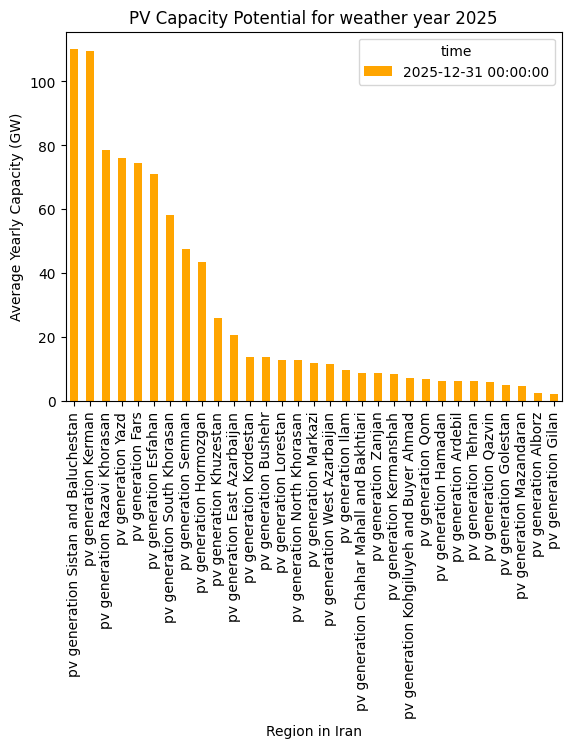

In [66]:
#fig, ax = plt.subplots(figsize=(20, 6))
pv_capacity_per_region.resample("Y").mean().divide(1e3).T.sort_values(by="2025-12-31", ascending=False).plot(
    kind="bar",
    color="orange",
    xlabel="Region in Iran",
    ylabel="Average Yearly Capacity (GW)",
    title="PV Capacity Potential for weather year 2025"
)

## PyPSA model build (annual cost minimization)

Mori Notes on PYPSA Section:
*   DONE - are emissions of technologies considered? --> (n.carriers) adding them in carriers
*   DONE - why the function does not have any return? --> thats why all generators have no marginal costs in the model. Check (n.generators.marginal_cost) 
*   DONE - Sistan and Baluchestan also a persian_golf_region. I have added this
*   DONE - The Problem with load of 2013 and weather data 2025 --> reindex to hour of the year, or reindexing the load to 2025
*   DONE - Storage (H2 and hydrogen) parameters from costs data frame. (lifetime, marginal and capital costs etc.)

This section builds a PyPSA network with regional buses, load distribution by population, and conventional generation with costs from the technology-data repository (outputs).

In [67]:
#BUILD ANNUITY TO EVALUATE COST
discount_rate = 0.07
cost_year = 2025
def annuity(rate, lifetime):
    return rate / (1 - (1 + rate) ** (-lifetime))
ONLY_GAS_PP_TECH = "CCGT"

#DEFINE COSTS
costs = pd.read_csv(f"data/costs_{cost_year}.csv")

def cost_params(tech):
    tech_data = costs[costs["technology"] == tech].set_index("parameter")["value"]
    return tech_data
    
def capital_cost(tech):
    tech_data = cost_params(tech)
    investment = tech_data.get("investment", 0.0)
    lifetime = tech_data.get("lifetime", 1.0)
    fom = tech_data.get("FOM", 0.0) / 100.0
    return annuity(discount_rate, lifetime) * investment + fom * investment

def marginal_cost(tech):
    if tech.lower().strip() == "gas": # it is considered that the only Gas technology is CCGT
        gas_data = cost_params(tech)
        pp_data = cost_params(ONLY_GAS_PP_TECH)
        
        fuel = gas_data.get("fuel", 0.0) # fuel price of gas
        
        efficiency = pp_data.get("efficiency", 1.0) # efficiency and vom of CCGT
        vom = pp_data.get("VOM", 0.0)
    
    else:
        tech_data = cost_params(tech)

        vom = tech_data.get("VOM", 0.0)
        efficiency = tech_data.get("efficiency", 1.0)
        fuel = tech_data.get("fuel", 0.0)

    return vom + fuel/efficiency

def co2_emission(tech):
    tech_data = cost_params(tech.lower().strip())
    
    co2_intensity = tech_data.get("CO2 intensity", 0.0) # in tCO2/MWh_th
    if tech == "gas":
        pp_data = cost_params(ONLY_GAS_PP_TECH)
        efficiency = pp_data.get("efficiency", 1.0) # in MWh_el/MWh_th
    
    efficiency = tech_data.get("efficiency", 1.0) # in MWh_el/MWh_th

    return co2_intensity / efficiency # in tCO2/MWh_el

In [68]:

# Time resolution and snapshots
# (We define the time steps the model will simulate.

# Load from 2013 vs generation based on weather of 2025 --> 
# Reindexing the Load to 2025

load_reg_3h = load_reg_1h.resample("3h").mean()
load_reg_3h.index = load_reg_3h.index.map(lambda t: t.replace(year=2025))
load_reg_3h = load_reg_3h.sort_index()

n = pypsa.Network()
n.set_snapshots(load_reg_3h.index)

# Name mapping between Load-region names and GADM names
# (We fix spelling differences so regions match between datasets.)

name_map = {
    "Ardabil": "Ardebil",
    "Isfahan": "Esfahan",
    "East Azerbaijan": "East Azarbaijan",
    "West Azerbaijan": "West Azarbaijan",
    "Chaharmahal and Bakhtiari": "Chahar Mahall and Bakhtiari",
    "Kohgiluyeh and Boyer-Ahmad": "Kohgiluyeh and Buyer Ahmad",
    "Kurdistan": "Kordestan",
}
inv_name_map = {v: k for k, v in name_map.items()}  # GADM -> Load/Bus name

regions = list(load_reg_3h.columns)


#  Create buses with representative points
# (We create one bus per region and set bus coordinates from the region geometry.

gadm = gadm_ir.copy().set_index("NAME_1")
rep = gadm.geometry.representative_point()

for r in regions:
    gadm_r = name_map.get(r, r)  # Load-name -> GADM-name
    if gadm_r not in rep.index:
        raise KeyError(f"Region '{r}' maps to '{gadm_r}' but it is not in gadm_ir['NAME_1']")
    p = rep.loc[gadm_r]
    n.add("Bus", name=r, x=float(p.x), y=float(p.y), carrier="AC")


# Add loads (demand) to each region bus
# (We attach the regional time series demand to its corresponding bus.)
for r in regions:
    n.add("Load", name=f"load_{r}", bus=r, p_set=load_reg_3h[r])


# Assign each power plant to a region (spatial join)
# (We find the region where each plant is located using its point coordinates.)

gadm_poly = gadm_ir[["NAME_1", "geometry"]].copy()
if pp_ir.crs != gadm_poly.crs:
    gadm_poly = gadm_poly.to_crs(pp_ir.crs)

pp_reg = gpd.sjoin(pp_ir, gadm_poly, how="inner", predicate="within")  # adds NAME_1 to each plant


# Filter out wind and solar plants
# (The existing fleet should exclude wind and solar.)

pp_reg = pp_reg[~pp_reg["primary_fuel"].isin(["Wind", "Solar","Hydro"])].copy() # Hydro will be added to the model in the next Section


# Aggregate existing plants to one generator per technology and region
# (We sum capacities so we add only one representative generator per fuel per region.)
agg = (
    pp_reg.groupby(["NAME_1", "primary_fuel"], as_index=False)["capacity_mw"]
    .sum()
)


# Add the existing conventional generators to PyPSA (non-extendable)
# (These generators have fixed capacity; the model can dispatch them but cannot expand them.)
for _, row in agg.iterrows():
    gadm_reg = row["NAME_1"]
    fuel = row["primary_fuel"].lower()
    p_nom = float(row["capacity_mw"])

    # Convert GADM region name to the Bus name used in the network (load names)
    bus = inv_name_map.get(gadm_reg, gadm_reg)

    # Skip if the bus is not in the model (e.g., region not modeled)
    if bus not in n.buses.index:
        continue

    n.add(
        "Generator",
        name=f"exist_{fuel}_{bus}",
        bus=bus,
        carrier=fuel,            # keep fuel name as carrier (simple)
        p_nom=p_nom,             # existing installed capacity (MW)
        p_nom_extendable=False,  #  not expandable
        marginal_cost=marginal_cost(fuel)         
    )




### HYDRO GENERATORS

In [69]:
#  Add simplified hydro generators=constant capacity factor
# (Hydro is modeled as a generator limited by a constant p_max_pu = annual_gen / (p_nom*8760).)

# Choose the year of historical hydro generation to use
# (We will use the dataset's estimated annual generation for this year.)

year = 2017
gen_col = f"estimated_generation_gwh_{year}"  # unit: GWh/year


#  Filter hydro power plants and keep only rows with available generation
# (We only take Hydro plants and require a non-missing annual generation value.)

hydro_pp = pp_ir[(pp_ir["primary_fuel"] == "Hydro") & (pp_ir[gen_col].notna())].copy()


# Assign each hydro plant to a region (spatial join)
# (We attach the region name NAME_1 to each plant based on its location.)
gadm_poly = gadm_ir[["NAME_1", "geometry"]].copy()

# Make sure both GeoDataFrames use the same CRS before spatial operations
if hydro_pp.crs != gadm_poly.crs:
    gadm_poly = gadm_poly.to_crs(hydro_pp.crs)

# Spatial join: each plant point gets the NAME_1 of the polygon it falls within
hydro_reg = gpd.sjoin(hydro_pp, gadm_poly, how="inner", predicate="within")


#  Aggregate hydro to one row per region
# (We sum installed capacity and annual generation across all hydro plants in the region.)

hydro_region = (
    hydro_reg.groupby("NAME_1")
    .agg(
        p_nom_mw=("capacity_mw", "sum"),      # MW
        gen_gwh_year=(gen_col, "sum")         # GWh/year
    )
    .reset_index()
)

# Compute a constant availability factor p_max_pu for each region
# (p_max_pu = annual_generation / (installed_capacity * hours_per_year).)
# p_nom_mw * 8760 h gives MWh/year
hours_per_year = 8760.0  
hydro_region["p_max_pu"] = (hydro_region["gen_gwh_year"] * 1000.0) / (hydro_region["p_nom_mw"] * hours_per_year)
hydro_region["p_max_pu"] = hydro_region["p_max_pu"].clip(0.0, 1.0)  # keep within [0,1]

# Add hydro generators to the PyPSA network
inv_name_map = {v: k for k, v in name_map.items()}  # GADM -> load/bus name

for _, row in hydro_region.iterrows():
    gadm_reg = row["NAME_1"]
    bus = inv_name_map.get(gadm_reg, gadm_reg)

    # Skip regions that are not part of the network buses
    if bus not in n.buses.index:
        continue

    n.add(
        "Generator",
        name=f"hydro_{bus}",
        bus=bus,
        carrier="hydro",
        p_nom=float(row["p_nom_mw"]),        # MW
        p_nom_extendable=False,
        p_max_pu=float(row["p_max_pu"]),     
        marginal_cost=0.0                 
    )



### INTRODUCTION OF SOLAR AND WIND POTENTIAL

In [70]:
#Add one solar and on-/offshore wind generator per region to the model, including the maximum 
#installable potential (p_nom_max) and capacity factor time series (p_max_pu). Assume a starting capacity of zero.

#WHY DO WE USE LOAD FROM 2013 COMPARED TO PRODUCTION IN 2025 ? CAN WE DO THIS ? 
pv = pv_capacity_per_region.copy()
#pv.index = pv.index.map(lambda t: t.replace(year=2013))
pv = pv.sort_index()
pv_3h = pv.resample("3h").mean().reindex(n.snapshots).fillna(0.0)

won = wind_on_capacity_per_region.copy()
#won.index = won.index.map(lambda t: t.replace(year=2013))
won = won.sort_index()
wind_on_3h = won.resample("3h").mean().reindex(n.snapshots).fillna(0.0)

woff = wind_off_capacity_per_region.copy()
#woff.index = woff.index.map(lambda t: t.replace(year=2013))
woff = woff.sort_index()
wind_off_3h = woff.resample("3h").mean().reindex(n.snapshots).fillna(0.0)

#RENAME COLUMNS TO MATCH WITH BUS
def strip_prefix(cols, prefix):
    return [c.replace(prefix, "").strip() for c in cols]

wind_on_3h.columns = strip_prefix(wind_on_3h.columns, "wind onshore generation")
pv_3h.columns = strip_prefix(pv_3h.columns, "pv generation")

#CONVERT NAME GADM IN NAME== BUS 
inv_name_map = {v: k for k, v in name_map.items()}  # GADM -> Bus(load-name)

pv_3h = pv_3h.rename(columns=inv_name_map)
wind_on_3h = wind_on_3h.rename(columns=inv_name_map)

#FIND MAX GENERATION 
def make_potential_and_cf(gen_mw_df):
    p_nom_max = gen_mw_df.max(axis=0).clip(lower=0.0)                # MW
    p_max_pu  = gen_mw_df.divide(p_nom_max.replace(0.0, np.nan), axis=1).fillna(0.0)
    p_max_pu  = p_max_pu.clip(0.0, 1.0)                               # 0..1
    return p_nom_max, p_max_pu

pv_p_nom_max, pv_cf = make_potential_and_cf(pv_3h)
on_p_nom_max, on_cf = make_potential_and_cf(wind_on_3h)

#OFFSHORE GENERATION IS ONLY IN REGIONS CONNECTED TO THE SEA  
#WHICH REGIONS ARE CONNECTED TO THE SEA ? 
persian_gulf_regions = ["Khuzestan", "Bushehr", "Hormozgan", "Sistan and Baluchestan"]   
caspian_regions      = ["Gilan", "Mazandaran", "Golestan"]

#  DataFrame offshore FOR REGION(MW) SINCE I HAVE DATA OFFSHORE FOR SEA I WILL GIVE AN EQUAL SHARE OF PRODUCTION TO EACH REGION ON THE RELATIVE SEA
off_gen = pd.DataFrame(0.0, index=n.snapshots, columns=n.buses.index)

if "wind_offshore generation Persian Gulf" in wind_off_3h.columns:
    pg = wind_off_3h["wind_offshore generation Persian Gulf"].reindex(n.snapshots).fillna(0.0)
    share = 1.0 / len(persian_gulf_regions)
    for r in persian_gulf_regions:
        if r in off_gen.columns:
            off_gen[r] += pg * share

if "wind_offshore generation Caspian Sea" in wind_off_3h.columns:
    cs = wind_off_3h["wind_offshore generation Caspian Sea"].reindex(n.snapshots).fillna(0.0)
    share = 1.0 / len(caspian_regions)
    for r in caspian_regions:
        if r in off_gen.columns:
            off_gen[r] += cs * share

off_p_nom_max, off_cf = make_potential_and_cf(off_gen)


#ADD ONE SOLAR AND ON/OFF SHORE 

for r in n.buses.index:
    # ---- SOLAR ----
    n.add(
        "Generator",
        name=f"solar_{r}",
        bus=r,
        carrier="solar",
        p_nom=0.0,                       # MW (starting capacity)
        p_nom_extendable=True,
        p_nom_max=float(pv_p_nom_max.get(r, 0.0)),   # MW
        p_max_pu=pv_cf[r] if r in pv_cf.columns else 0.0,
        capital_cost=capital_cost("solar"),
        marginal_cost=marginal_cost("solar"),
    )

    # ---- ONWIND ----
    n.add(
        "Generator",
        name=f"onwind_{r}",
        bus=r,
        carrier="onwind",
        p_nom=0.0,
        p_nom_extendable=True,
        p_nom_max=float(on_p_nom_max.get(r, 0.0)),   # MW
        p_max_pu=on_cf[r] if r in on_cf.columns else 0.0,
        capital_cost=capital_cost("onwind"),
        marginal_cost=marginal_cost("onwind"),
    )

    # ---- OFFWIND ----
for r in n.buses.index:

    # OFFWIND only if region has offshore potential
    if off_p_nom_max.get(r, 0.0) > 0:
        n.add(
            "Generator",
            name=f"offwind_{r}",
            bus=r,
            carrier="offwind",
            p_nom=0.0,
            p_nom_extendable=True,
            p_nom_max=float(off_p_nom_max[r]),
            p_max_pu=off_cf[r],
            capital_cost=capital_cost("offwind"),
            marginal_cost=marginal_cost("offwind"),
        )


### ADD LINKS

In [71]:
#prepare geometries in a metric CRS to measure distances in meters 
#For each region, we compute a representative point that will be used to approximate the region’s location.
gadm = gadm_ir[["NAME_1","geometry"]].copy()
gadm = gadm.to_crs(epsg=3857)  # meters
gadm["rep"] = gadm.geometry.representative_point()

# map GADM region names to PyPSA bus names
def gadm_to_bus(name_1):
    return inv_name_map.get(name_1, name_1)

# build a list of neighbouring region pairs 
#We identify neighbouring regions by checking which region polygons touch each other.
#Each neighbouring pair is stored and will later be connected by a transmission line.
pairs = []
for i, row_i in gadm.iterrows():
    for j, row_j in gadm.iterrows():
        if j <= i:
            continue
        if row_i.geometry.touches(row_j.geometry):
            pairs.append((row_i["NAME_1"], row_j["NAME_1"]))

#transmission assumptions
capex_per_mw_km = 700.0  # €/MW/km
lifetime_line = 40
a_line = annuity(discount_rate, lifetime_line)

# add bidirectional transmission links between neighbouring regions
for r1, r2 in pairs:
    b1, b2 = gadm_to_bus(r1), gadm_to_bus(r2)
    if b1 not in n.buses.index or b2 not in n.buses.index:
        continue        
    #We extract the representative points of the two neighbouring regions in order to compute the distance between them.
    p1 = gadm.loc[gadm["NAME_1"] == r1, "rep"].values[0]
    p2 = gadm.loc[gadm["NAME_1"] == r2, "rep"].values[0]
    dist_km = (p1.distance(p2) / 1000.0) * 1.5   
    capital_cost_line = a_line * capex_per_mw_km * dist_km


    n.add(
        "Link",
        name=f"line_{b1}__{b2}",
        bus0=b1,
        bus1=b2,
        p_nom_extendable=True,
        p_min_pu=-1,
        efficiency=1.0,
        capital_cost=capital_cost_line
    )


### BATTERY STORAGE

In [72]:
cost_params("battery storage").get("investment", 0.0)*1000

np.float64(198855.8)

In [73]:
cost_params("battery storage").get("lifetime", 15.0)

np.float64(22.5)

In [74]:
# COST: HOW TO CHOOSE THEM ??
#battery_power_cost = 150000  # €/MW (inverter + power part)
#battery_energy_cost = 120000 # €/MWh (cells)
#battery_lifetime = 15

battery_power_cost = 0 # Assumption
battery_energy_cost = cost_params("battery storage").get("investment", 0.0) * 1000 # in €/kWh * 1000 = €/MWh
battery_lifetime = cost_params("battery storage").get("lifetime", 15.0)

a_bat = annuity(discount_rate, battery_lifetime)

for r in n.buses.index:
    for h in [2 , 4, 6]:
        capex_per_mw = battery_power_cost + battery_energy_cost * h  # €/MW
        n.add(
            "StorageUnit",
            name=f"battery_{h}h_{r}",
            bus=r,
            carrier="battery storage",
            p_nom=0.0,
            p_nom_extendable=True,
            max_hours=h,                   # energy-to-power ratio (h)
            efficiency_store=0.95,
            efficiency_dispatch=0.95,
            capital_cost=a_bat * capex_per_mw,  # €/MW/year
            marginal_cost=0.0
        )


### HYDROGEN STORAGE

In [75]:
cost_params("hydrogen storage underground")

parameter
FOM             0.0000
VOM             0.0000
investment      2.6585
lifetime      100.0000
Name: value, dtype: float64

In [76]:
cost_params("hydrogen storage tank type 1").get("FOM")/100

np.float64(0.02)

In [77]:
# WHICH COST SHOULD WE USE ?? MAYBE FIND THEM IN CSV_2030??
#h2_power_cost = 400000   # €/MW (power part: electrolyzer+fuel cell equivalent )
#h2_energy_cost = 1000    # €/MWh (storage cavern/energy part)
#h2_lifetime = 20

h2_power_cost = 0 # Assumption
h2_energy_cost = cost_params("hydrogen storage tank type 1").get("investment", 0.0) * 1000 # in €/kWh_H2 * 1000 = €/MWh_H2
h2_FOM_cost = cost_params("hydrogen storage tank type 1").get("FOM", 0.0)/100 # = %/year
h2_lifetime = cost_params("hydrogen storage tank type 1").get("lifetime", 20.0)

a_h2 = annuity(discount_rate, h2_lifetime)

for r in n.buses.index:
    for h in [168 , 336, 672]:
        capex_per_mw = h2_power_cost + h2_energy_cost * h
        n.add(
            "StorageUnit",
            name=f"h2_{h}h_{r}",
            bus=r,
            carrier="H2",
            p_nom=0.0,
            p_nom_extendable=True,
            max_hours=h,
            efficiency_store=0.70,         # electrolyzer 
            efficiency_dispatch=0.55,      # fuel cell/turbine 
            capital_cost=a_h2 * capex_per_mw + h2_FOM_cost + capex_per_mw, # investment + FOM
            marginal_cost=0.0
        )


In [78]:
n.storage_units

bus control type  p_nom  p_nom_mod  p_nom_extendable  \
name                                                                           
battery_2h_Alborz    Alborz      PQ         0.0        0.0              True   
battery_4h_Alborz    Alborz      PQ         0.0        0.0              True   
battery_6h_Alborz    Alborz      PQ         0.0        0.0              True   
battery_2h_Ardabil  Ardabil      PQ         0.0        0.0              True   
battery_4h_Ardabil  Ardabil      PQ         0.0        0.0              True   
...                     ...     ...  ...    ...        ...               ...   
h2_336h_Yazd           Yazd      PQ         0.0        0.0              True   
h2_672h_Yazd           Yazd      PQ         0.0        0.0              True   
h2_168h_Zanjan       Zanjan      PQ         0.0        0.0              True   
h2_336h_Zanjan       Zanjan      PQ         0.0        0.0              True   
h2_672h_Zanjan       Zanjan      PQ         0.0        0.0              True   

                    p_nom_min  p_nom_max  p_nom_set  p_min_pu  ...  \
name                                                           ...   
battery_2h_Alborz         0.0        inf        NaN      -1.0  ...   
battery_4h_Alborz         0.0        inf        NaN      -1.0  ...   
battery_6h_Alborz         0.0        inf        NaN      -1.0  ...   
battery_2h_Ardabil        0.0        inf        NaN      -1.0  ...   
battery_4h_Ardabil        0.0        inf        NaN      -1.0  ...   
...                       ...        ...        ...       ...  ...   
h2_336h_Yazd              0.0        inf        NaN      -1.0  ...   
h2_672h_Yazd              0.0        inf        NaN      -1.0  ...   
h2_168h_Zanjan            0.0        inf        NaN      -1.0  ...   
h2_336h_Zanjan            0.0        inf        NaN      -1.0  ...   
h2_672h_Zanjan            0.0        inf        NaN      -1.0  ...   

                    state_of_charge_initial_per_period  state_of_charge_set  \
name                                                                          
battery_2h_Alborz                                False                  NaN   
battery_4h_Alborz                                False                  NaN   
battery_6h_Alborz                                False                  NaN   
battery_2h_Ardabil                               False                  NaN   
battery_4h_Ardabil                               False                  NaN   
...                                                ...                  ...   
h2_336h_Yazd                                     False                  NaN   
h2_672h_Yazd                                     False                  NaN   
h2_168h_Zanjan                                   False                  NaN   
h2_336h_Zanjan                                   False                  NaN   
h2_672h_Zanjan                                   False                  NaN   

                    cyclic_state_of_charge  cyclic_state_of_charge_per_period  \
name                                                                            
battery_2h_Alborz                    False                              False   
battery_4h_Alborz                    False                              False   
battery_6h_Alborz                    False                              False   
battery_2h_Ardabil                   False                              False   
battery_4h_Ardabil                   False                              False   
...                                    ...                                ...   
h2_336h_Yazd                         False                              False   
h2_672h_Yazd                         False                              False   
h2_168h_Zanjan                       False                              False   
h2_336h_Zanjan                       False                              False   
h2_672h_Zanjan                       False                              

### Adding Carriers and their emissions

In [79]:
#  define carriers
carriers = [
    "AC", "gas", "oil", "nuclear", "hydro",
    "solar", "onwind", "offwind",
    "battery storage", "H2"
]

colors = [
    "black", "red", "brown", "turquoise", "blue", 
    "gold", "dodgerblue", "aquamarine", 
    "yellowgreen", "magenta"
]


for c, color in zip(carriers, colors):
    if c not in n.carriers.index:
        n.add("Carrier",
            name=c,
            co2_emissions=co2_emission(c),
            color=color
            )

In [80]:
n.carriers

co2_emissions        color nice_name  max_growth  \
name                                                                
AC                    0.000000        black                   inf   
gas                   0.198000          red                   inf   
oil                   0.734571        brown                   inf   
nuclear               0.000000    turquoise                   inf   
hydro                 0.000000         blue                   inf   
solar                 0.000000         gold                   inf   
onwind                0.000000   dodgerblue                   inf   
offwind               0.000000   aquamarine                   inf   
battery storage       0.000000  yellowgreen                   inf   
H2                    0.000000      magenta                   inf   

                 max_relative_growth  
name                                  
AC                               0.0  
gas                              0.0  
oil                              0.0  
nuclear                          0.0  
hydro                            0.0  
solar                            0.0  
onwind                           0.0  
offwind                          0.0  
battery storage                  0.0  
H2                               0.0

### SOLVE THE Pypsa MODEL 

In [81]:
# solve the model
#n.optimize(solver_name="highs")
n.optimize(
    #snapshots=n.snapshots[:168],  # 1 week
    solver_name="gurobi"
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 49.44it/s]
INFO:linopy.io: Writing time: 4.09s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2750042


INFO:gurobipy:Set parameter LicenseID to value 2750042


Academic license - for non-commercial use only - expires 2026-12-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-12-04


Read LP format model from file /private/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/linopy-problem-kaxzddo1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/linopy-problem-kaxzddo1.lp


Reading time = 4.24 seconds


INFO:gurobipy:Reading time = 4.24 seconds


obj: 5019878 rows, 2193249 columns, 10649033 nonzeros


INFO:gurobipy:obj: 5019878 rows, 2193249 columns, 10649033 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 14 physical cores, 14 logical processors, using up to 14 threads


INFO:gurobipy:Thread count: 14 physical cores, 14 logical processors, using up to 14 threads


INFO:gurobipy:


Optimize a model with 5019878 rows, 2193249 columns and 10649033 nonzeros (Min)


INFO:gurobipy:Optimize a model with 5019878 rows, 2193249 columns and 10649033 nonzeros (Min)


Model fingerprint: 0x119db3dc


INFO:gurobipy:Model fingerprint: 0x119db3dc


Model has 318609 linear objective coefficients


INFO:gurobipy:Model has 318609 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 7e+02]


INFO:gurobipy:  Matrix range     [2e-10, 7e+02]


  Objective range  [1e-02, 1e+07]


INFO:gurobipy:  Objective range  [1e-02, 1e+07]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+00, 4e+05]


INFO:gurobipy:  RHS range        [2e+00, 4e+05]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 2377883 rows and 38565 columns (presolve time = 6s)...


INFO:gurobipy:Presolve removed 2377883 rows and 38565 columns (presolve time = 6s)...


Presolve removed 2377883 rows and 38565 columns


INFO:gurobipy:Presolve removed 2377883 rows and 38565 columns


Presolve time: 7.23s


INFO:gurobipy:Presolve time: 7.23s


Presolved: 2641995 rows, 2154684 columns, 8448665 nonzeros


INFO:gurobipy:Presolved: 2641995 rows, 2154684 columns, 8448665 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 9.21s


INFO:gurobipy:Ordering time: 9.21s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 329


INFO:gurobipy: Dense cols : 329


 AA' NZ     : 7.597e+06


INFO:gurobipy: AA' NZ     : 7.597e+06


 Factor NZ  : 6.784e+07 (roughly 2.5 GB of memory)


INFO:gurobipy: Factor NZ  : 6.784e+07 (roughly 2.5 GB of memory)


 Factor Ops : 2.394e+10 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.394e+10 (less than 1 second per iteration)


 Threads    : 12


INFO:gurobipy: Threads    : 12


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.90816722e+12 -1.74046064e+12  5.75e+05 9.24e+01  8.72e+08    19s


INFO:gurobipy:   0   2.90816722e+12 -1.74046064e+12  5.75e+05 9.24e+01  8.72e+08    19s


   1   3.59970393e+12 -1.74272439e+12  4.40e+05 6.81e+03  7.70e+08    19s


INFO:gurobipy:   1   3.59970393e+12 -1.74272439e+12  4.40e+05 6.81e+03  7.70e+08    19s


   2   3.85270081e+12 -1.96474832e+12  4.06e+05 5.45e+03  6.53e+08    20s


INFO:gurobipy:   2   3.85270081e+12 -1.96474832e+12  4.06e+05 5.45e+03  6.53e+08    20s


   3   4.68564461e+12 -3.35872839e+12  3.20e+05 2.04e+03  3.46e+08    20s


INFO:gurobipy:   3   4.68564461e+12 -3.35872839e+12  3.20e+05 2.04e+03  3.46e+08    20s


   4   6.43906494e+12 -3.92732771e+12  2.44e+05 8.15e+02  1.89e+08    21s


INFO:gurobipy:   4   6.43906494e+12 -3.92732771e+12  2.44e+05 8.15e+02  1.89e+08    21s


   5   1.46908669e+13 -4.06655103e+12  9.83e+04 3.34e+02  7.53e+07    22s


INFO:gurobipy:   5   1.46908669e+13 -4.06655103e+12  9.83e+04 3.34e+02  7.53e+07    22s


   6   1.67373979e+13 -3.78059607e+12  4.82e+04 1.34e+02  3.42e+07    22s


INFO:gurobipy:   6   1.67373979e+13 -3.78059607e+12  4.82e+04 1.34e+02  3.42e+07    22s


   7   1.48475156e+13 -3.30928498e+12  2.81e+04 6.46e+01  1.85e+07    23s


INFO:gurobipy:   7   1.48475156e+13 -3.30928498e+12  2.81e+04 6.46e+01  1.85e+07    23s


   8   1.28619477e+13 -2.66277531e+12  2.11e+04 2.75e+01  1.12e+07    24s


INFO:gurobipy:   8   1.28619477e+13 -2.66277531e+12  2.11e+04 2.75e+01  1.12e+07    24s


   9   8.48029442e+12 -2.27749131e+12  1.11e+04 1.70e+01  6.31e+06    24s


INFO:gurobipy:   9   8.48029442e+12 -2.27749131e+12  1.11e+04 1.70e+01  6.31e+06    24s


  10   5.29381044e+12 -1.80967305e+12  5.63e+03 1.01e+01  3.45e+06    24s


INFO:gurobipy:  10   5.29381044e+12 -1.80967305e+12  5.63e+03 1.01e+01  3.45e+06    24s


  11   3.15519240e+12 -1.23879376e+12  2.87e+03 5.28e+00  1.78e+06    25s


INFO:gurobipy:  11   3.15519240e+12 -1.23879376e+12  2.87e+03 5.28e+00  1.78e+06    25s


  12   1.95002693e+12 -7.56470150e+11  1.51e+03 2.38e+00  9.41e+05    25s


INFO:gurobipy:  12   1.95002693e+12 -7.56470150e+11  1.51e+03 2.38e+00  9.41e+05    25s


  13   1.48081597e+12 -4.57856054e+11  1.08e+03 1.16e+00  6.20e+05    26s


INFO:gurobipy:  13   1.48081597e+12 -4.57856054e+11  1.08e+03 1.16e+00  6.20e+05    26s


  14   9.34393519e+11 -3.22363744e+11  6.32e+02 7.30e-01  3.77e+05    26s


INFO:gurobipy:  14   9.34393519e+11 -3.22363744e+11  6.32e+02 7.30e-01  3.77e+05    26s


  15   6.60236063e+11 -1.93558340e+11  4.26e+02 3.56e-01  2.44e+05    27s


INFO:gurobipy:  15   6.60236063e+11 -1.93558340e+11  4.26e+02 3.56e-01  2.44e+05    27s


  16   4.49185457e+11 -1.16985896e+11  2.81e+02 2.03e-01  1.56e+05    27s


INFO:gurobipy:  16   4.49185457e+11 -1.16985896e+11  2.81e+02 2.03e-01  1.56e+05    27s


  17   2.42307796e+11 -7.17972637e+10  1.42e+02 8.44e-02  8.30e+04    28s


INFO:gurobipy:  17   2.42307796e+11 -7.17972637e+10  1.42e+02 8.44e-02  8.30e+04    28s


  18   1.15632847e+11 -3.48673787e+10  6.26e+01 3.11e-02  3.83e+04    28s


INFO:gurobipy:  18   1.15632847e+11 -3.48673787e+10  6.26e+01 3.11e-02  3.83e+04    28s


  19   6.85364629e+10 -1.54779921e+10  3.51e+01 7.33e-03  2.10e+04    29s


INFO:gurobipy:  19   6.85364629e+10 -1.54779921e+10  3.51e+01 7.33e-03  2.10e+04    29s


  20   4.10281092e+10 -9.87768146e+09  2.03e+01 5.18e-03  1.25e+04    29s


INFO:gurobipy:  20   4.10281092e+10 -9.87768146e+09  2.03e+01 5.18e-03  1.25e+04    29s


  21   2.36963674e+10 -5.68948675e+09  1.12e+01 2.00e-08  7.13e+03    30s


INFO:gurobipy:  21   2.36963674e+10 -5.68948675e+09  1.12e+01 2.00e-08  7.13e+03    30s


  22   1.36961217e+10 -2.94028812e+09  6.01e+00 1.58e-08  3.99e+03    30s


INFO:gurobipy:  22   1.36961217e+10 -2.94028812e+09  6.01e+00 1.58e-08  3.99e+03    30s


  23   9.08565121e+09 -1.93029331e+09  3.67e+00 1.14e-08  2.62e+03    31s


INFO:gurobipy:  23   9.08565121e+09 -1.93029331e+09  3.67e+00 1.14e-08  2.62e+03    31s


  24   7.50571815e+09 -8.69364402e+08  2.87e+00 9.13e-09  1.99e+03    31s


INFO:gurobipy:  24   7.50571815e+09 -8.69364402e+08  2.87e+00 9.13e-09  1.99e+03    31s


  25   6.36424467e+09 -4.79216401e+08  2.31e+00 6.86e-09  1.62e+03    32s


INFO:gurobipy:  25   6.36424467e+09 -4.79216401e+08  2.31e+00 6.86e-09  1.62e+03    32s


  26   5.70095767e+09 -1.70289817e+08  1.99e+00 5.70e-09  1.39e+03    32s


INFO:gurobipy:  26   5.70095767e+09 -1.70289817e+08  1.99e+00 5.70e-09  1.39e+03    32s


  27   5.13219155e+09  2.96915395e+08  1.72e+00 4.10e-09  1.14e+03    33s


INFO:gurobipy:  27   5.13219155e+09  2.96915395e+08  1.72e+00 4.10e-09  1.14e+03    33s


  28   4.77468151e+09  4.84648622e+08  1.56e+00 3.22e-09  1.01e+03    33s


INFO:gurobipy:  28   4.77468151e+09  4.84648622e+08  1.56e+00 3.22e-09  1.01e+03    33s


  29   4.40043239e+09  5.85270231e+08  1.39e+00 3.22e-09  9.02e+02    34s


INFO:gurobipy:  29   4.40043239e+09  5.85270231e+08  1.39e+00 3.22e-09  9.02e+02    34s


  30   3.88948296e+09  6.67119472e+08  1.15e+00 3.28e-09  7.60e+02    35s


INFO:gurobipy:  30   3.88948296e+09  6.67119472e+08  1.15e+00 3.28e-09  7.60e+02    35s


  31   3.81980657e+09  6.93458508e+08  1.12e+00 3.02e-09  7.38e+02    35s


INFO:gurobipy:  31   3.81980657e+09  6.93458508e+08  1.12e+00 3.02e-09  7.38e+02    35s


  32   3.54296694e+09  7.31736857e+08  9.91e-01 3.21e-09  6.63e+02    36s


INFO:gurobipy:  32   3.54296694e+09  7.31736857e+08  9.91e-01 3.21e-09  6.63e+02    36s


  33   3.19138810e+09  8.34746192e+08  8.34e-01 2.82e-09  5.55e+02    37s


INFO:gurobipy:  33   3.19138810e+09  8.34746192e+08  8.34e-01 2.82e-09  5.55e+02    37s


  34   2.82142986e+09  9.09685823e+08  6.61e-01 2.80e-09  4.50e+02    38s


INFO:gurobipy:  34   2.82142986e+09  9.09685823e+08  6.61e-01 2.80e-09  4.50e+02    38s


  35   2.71077474e+09  9.39955625e+08  6.09e-01 2.77e-09  4.16e+02    38s


INFO:gurobipy:  35   2.71077474e+09  9.39955625e+08  6.09e-01 2.77e-09  4.16e+02    38s


  36   2.63074152e+09  9.65116250e+08  5.71e-01 2.57e-09  3.91e+02    39s


INFO:gurobipy:  36   2.63074152e+09  9.65116250e+08  5.71e-01 2.57e-09  3.91e+02    39s


  37   2.52729968e+09  1.01633156e+09  5.23e-01 2.64e-09  3.55e+02    40s


INFO:gurobipy:  37   2.52729968e+09  1.01633156e+09  5.23e-01 2.64e-09  3.55e+02    40s


  38   2.34099362e+09  1.06523097e+09  4.31e-01 2.64e-09  2.99e+02    41s


INFO:gurobipy:  38   2.34099362e+09  1.06523097e+09  4.31e-01 2.64e-09  2.99e+02    41s


  39   2.16222391e+09  1.12025419e+09  3.48e-01 3.42e-09  2.44e+02    42s


INFO:gurobipy:  39   2.16222391e+09  1.12025419e+09  3.48e-01 3.42e-09  2.44e+02    42s


  40   2.11415305e+09  1.14916991e+09  3.25e-01 3.68e-09  2.26e+02    42s


INFO:gurobipy:  40   2.11415305e+09  1.14916991e+09  3.25e-01 3.68e-09  2.26e+02    42s


  41   2.05442711e+09  1.17307403e+09  2.96e-01 3.66e-09  2.07e+02    43s


INFO:gurobipy:  41   2.05442711e+09  1.17307403e+09  2.96e-01 3.66e-09  2.07e+02    43s


  42   2.00365453e+09  1.20258606e+09  2.72e-01 3.94e-09  1.88e+02    44s


INFO:gurobipy:  42   2.00365453e+09  1.20258606e+09  2.72e-01 3.94e-09  1.88e+02    44s


  43   1.94677016e+09  1.25442451e+09  2.45e-01 4.57e-09  1.63e+02    45s


INFO:gurobipy:  43   1.94677016e+09  1.25442451e+09  2.45e-01 4.57e-09  1.63e+02    45s


  44   1.87301017e+09  1.26924049e+09  2.09e-01 4.89e-09  1.42e+02    46s


INFO:gurobipy:  44   1.87301017e+09  1.26924049e+09  2.09e-01 4.89e-09  1.42e+02    46s


  45   1.82063364e+09  1.29037804e+09  1.85e-01 5.03e-09  1.24e+02    47s


INFO:gurobipy:  45   1.82063364e+09  1.29037804e+09  1.85e-01 5.03e-09  1.24e+02    47s


  46   1.77948682e+09  1.30603054e+09  1.65e-01 5.38e-09  1.11e+02    48s


INFO:gurobipy:  46   1.77948682e+09  1.30603054e+09  1.65e-01 5.38e-09  1.11e+02    48s


  47   1.74952155e+09  1.31814307e+09  1.51e-01 5.89e-09  1.01e+02    49s


INFO:gurobipy:  47   1.74952155e+09  1.31814307e+09  1.51e-01 5.89e-09  1.01e+02    49s


  48   1.73811161e+09  1.32347476e+09  1.45e-01 5.54e-09  9.72e+01    49s


INFO:gurobipy:  48   1.73811161e+09  1.32347476e+09  1.45e-01 5.54e-09  9.72e+01    49s


  49   1.69351811e+09  1.33271012e+09  1.24e-01 6.82e-09  8.45e+01    50s


INFO:gurobipy:  49   1.69351811e+09  1.33271012e+09  1.24e-01 6.82e-09  8.45e+01    50s


  50   1.66917131e+09  1.34713522e+09  1.12e-01 6.07e-09  7.55e+01    51s


INFO:gurobipy:  50   1.66917131e+09  1.34713522e+09  1.12e-01 6.07e-09  7.55e+01    51s


  51   1.63469030e+09  1.35646510e+09  9.55e-02 7.87e-09  6.52e+01    52s


INFO:gurobipy:  51   1.63469030e+09  1.35646510e+09  9.55e-02 7.87e-09  6.52e+01    52s


  52   1.60405103e+09  1.37041118e+09  8.08e-02 8.28e-09  5.47e+01    53s


INFO:gurobipy:  52   1.60405103e+09  1.37041118e+09  8.08e-02 8.28e-09  5.47e+01    53s


  53   1.58981755e+09  1.37942707e+09  7.41e-02 9.15e-09  4.93e+01    54s


INFO:gurobipy:  53   1.58981755e+09  1.37942707e+09  7.41e-02 9.15e-09  4.93e+01    54s


  54   1.56742105e+09  1.38331747e+09  6.36e-02 9.21e-09  4.31e+01    55s


INFO:gurobipy:  54   1.56742105e+09  1.38331747e+09  6.36e-02 9.21e-09  4.31e+01    55s


  55   1.54539249e+09  1.38797973e+09  5.32e-02 1.05e-08  3.68e+01    56s


INFO:gurobipy:  55   1.54539249e+09  1.38797973e+09  5.32e-02 1.05e-08  3.68e+01    56s


  56   1.53325787e+09  1.39168841e+09  4.76e-02 1.10e-08  3.31e+01    57s


INFO:gurobipy:  56   1.53325787e+09  1.39168841e+09  4.76e-02 1.10e-08  3.31e+01    57s


  57   1.51843713e+09  1.40001256e+09  4.08e-02 1.17e-08  2.77e+01    58s


INFO:gurobipy:  57   1.51843713e+09  1.40001256e+09  4.08e-02 1.17e-08  2.77e+01    58s


  58   1.50958857e+09  1.40233397e+09  3.68e-02 1.19e-08  2.51e+01    58s


INFO:gurobipy:  58   1.50958857e+09  1.40233397e+09  3.68e-02 1.19e-08  2.51e+01    58s


  59   1.50474965e+09  1.40292590e+09  3.46e-02 1.24e-08  2.38e+01    59s


INFO:gurobipy:  59   1.50474965e+09  1.40292590e+09  3.46e-02 1.24e-08  2.38e+01    59s


  60   1.49690115e+09  1.40680362e+09  3.11e-02 1.25e-08  2.11e+01    60s


INFO:gurobipy:  60   1.49690115e+09  1.40680362e+09  3.11e-02 1.25e-08  2.11e+01    60s


  61   1.48808395e+09  1.41060216e+09  2.70e-02 1.33e-08  1.81e+01    61s


INFO:gurobipy:  61   1.48808395e+09  1.41060216e+09  2.70e-02 1.33e-08  1.81e+01    61s


  62   1.48282678e+09  1.41185078e+09  2.47e-02 1.29e-08  1.66e+01    62s


INFO:gurobipy:  62   1.48282678e+09  1.41185078e+09  2.47e-02 1.29e-08  1.66e+01    62s


  63   1.47547172e+09  1.41369133e+09  2.14e-02 1.41e-08  1.45e+01    63s


INFO:gurobipy:  63   1.47547172e+09  1.41369133e+09  2.14e-02 1.41e-08  1.45e+01    63s


  64   1.47237438e+09  1.41437322e+09  2.00e-02 1.46e-08  1.36e+01    63s


INFO:gurobipy:  64   1.47237438e+09  1.41437322e+09  2.00e-02 1.46e-08  1.36e+01    63s


  65   1.47064238e+09  1.41492904e+09  1.92e-02 1.40e-08  1.30e+01    64s


INFO:gurobipy:  65   1.47064238e+09  1.41492904e+09  1.92e-02 1.40e-08  1.30e+01    64s


  66   1.46482462e+09  1.41711852e+09  1.66e-02 1.39e-08  1.12e+01    65s


INFO:gurobipy:  66   1.46482462e+09  1.41711852e+09  1.66e-02 1.39e-08  1.12e+01    65s


  67   1.46126416e+09  1.41807655e+09  1.50e-02 1.47e-08  1.01e+01    66s


INFO:gurobipy:  67   1.46126416e+09  1.41807655e+09  1.50e-02 1.47e-08  1.01e+01    66s


  68   1.45714011e+09  1.41925869e+09  1.31e-02 1.33e-08  8.86e+00    67s


INFO:gurobipy:  68   1.45714011e+09  1.41925869e+09  1.31e-02 1.33e-08  8.86e+00    67s


  69   1.45331314e+09  1.42057748e+09  1.14e-02 1.43e-08  7.66e+00    67s


INFO:gurobipy:  69   1.45331314e+09  1.42057748e+09  1.14e-02 1.43e-08  7.66e+00    67s


  70   1.44907916e+09  1.42172554e+09  9.50e-03 1.38e-08  6.40e+00    68s


INFO:gurobipy:  70   1.44907916e+09  1.42172554e+09  9.50e-03 1.38e-08  6.40e+00    68s


  71   1.44693658e+09  1.42222063e+09  8.55e-03 1.35e-08  5.78e+00    69s


INFO:gurobipy:  71   1.44693658e+09  1.42222063e+09  8.55e-03 1.35e-08  5.78e+00    69s


  72   1.44464129e+09  1.42278300e+09  7.55e-03 1.37e-08  5.11e+00    70s


INFO:gurobipy:  72   1.44464129e+09  1.42278300e+09  7.55e-03 1.37e-08  5.11e+00    70s


  73   1.44413332e+09  1.42297625e+09  7.33e-03 1.40e-08  4.95e+00    71s


INFO:gurobipy:  73   1.44413332e+09  1.42297625e+09  7.33e-03 1.40e-08  4.95e+00    71s


  74   1.44223389e+09  1.42335832e+09  6.50e-03 1.46e-08  4.42e+00    72s


INFO:gurobipy:  74   1.44223389e+09  1.42335832e+09  6.50e-03 1.46e-08  4.42e+00    72s


  75   1.43951492e+09  1.42381477e+09  5.29e-03 1.37e-08  3.67e+00    73s


INFO:gurobipy:  75   1.43951492e+09  1.42381477e+09  5.29e-03 1.37e-08  3.67e+00    73s


  76   1.43795853e+09  1.42449479e+09  4.61e-03 1.40e-08  3.15e+00    74s


INFO:gurobipy:  76   1.43795853e+09  1.42449479e+09  4.61e-03 1.40e-08  3.15e+00    74s


  77   1.43704097e+09  1.42487063e+09  4.21e-03 1.42e-08  2.85e+00    75s


INFO:gurobipy:  77   1.43704097e+09  1.42487063e+09  4.21e-03 1.42e-08  2.85e+00    75s


  78   1.43592410e+09  1.42510997e+09  3.72e-03 1.24e-08  2.53e+00    76s


INFO:gurobipy:  78   1.43592410e+09  1.42510997e+09  3.72e-03 1.24e-08  2.53e+00    76s


  79   1.43492220e+09  1.42542458e+09  3.29e-03 1.27e-08  2.22e+00    77s


INFO:gurobipy:  79   1.43492220e+09  1.42542458e+09  3.29e-03 1.27e-08  2.22e+00    77s


  80   1.43353261e+09  1.42584015e+09  2.69e-03 1.14e-08  1.80e+00    78s


INFO:gurobipy:  80   1.43353261e+09  1.42584015e+09  2.69e-03 1.14e-08  1.80e+00    78s


  81   1.43285120e+09  1.42604666e+09  2.39e-03 1.18e-08  1.59e+00    79s


INFO:gurobipy:  81   1.43285120e+09  1.42604666e+09  2.39e-03 1.18e-08  1.59e+00    79s


  82   1.43165297e+09  1.42625879e+09  1.89e-03 1.04e-08  1.26e+00    80s


INFO:gurobipy:  82   1.43165297e+09  1.42625879e+09  1.89e-03 1.04e-08  1.26e+00    80s


  83   1.43100848e+09  1.42635411e+09  1.61e-03 1.11e-08  1.09e+00    80s


INFO:gurobipy:  83   1.43100848e+09  1.42635411e+09  1.61e-03 1.11e-08  1.09e+00    80s


  84   1.43038421e+09  1.42646277e+09  1.35e-03 9.68e-09  9.17e-01    81s


INFO:gurobipy:  84   1.43038421e+09  1.42646277e+09  1.35e-03 9.68e-09  9.17e-01    81s


  85   1.43001230e+09  1.42659237e+09  1.19e-03 1.12e-08  8.00e-01    82s


INFO:gurobipy:  85   1.43001230e+09  1.42659237e+09  1.19e-03 1.12e-08  8.00e-01    82s


  86   1.42958139e+09  1.42670863e+09  1.00e-03 1.08e-08  6.72e-01    83s


INFO:gurobipy:  86   1.42958139e+09  1.42670863e+09  1.00e-03 1.08e-08  6.72e-01    83s


  87   1.42913654e+09  1.42681145e+09  8.09e-04 9.15e-09  5.44e-01    84s


INFO:gurobipy:  87   1.42913654e+09  1.42681145e+09  8.09e-04 9.15e-09  5.44e-01    84s


  88   1.42883672e+09  1.42688811e+09  6.81e-04 1.21e-08  4.56e-01    84s


INFO:gurobipy:  88   1.42883672e+09  1.42688811e+09  6.81e-04 1.21e-08  4.56e-01    84s


  89   1.42849146e+09  1.42695664e+09  5.35e-04 1.32e-08  3.59e-01    85s


INFO:gurobipy:  89   1.42849146e+09  1.42695664e+09  5.35e-04 1.32e-08  3.59e-01    85s


  90   1.42831790e+09  1.42700002e+09  4.62e-04 1.29e-08  3.08e-01    86s


INFO:gurobipy:  90   1.42831790e+09  1.42700002e+09  4.62e-04 1.29e-08  3.08e-01    86s


  91   1.42822614e+09  1.42703229e+09  4.24e-04 1.21e-08  2.79e-01    87s


INFO:gurobipy:  91   1.42822614e+09  1.42703229e+09  4.24e-04 1.21e-08  2.79e-01    87s


  92   1.42805252e+09  1.42704511e+09  3.53e-04 1.18e-08  2.36e-01    87s


INFO:gurobipy:  92   1.42805252e+09  1.42704511e+09  3.53e-04 1.18e-08  2.36e-01    87s


  93   1.42794326e+09  1.42707178e+09  3.07e-04 1.26e-08  2.04e-01    88s


INFO:gurobipy:  93   1.42794326e+09  1.42707178e+09  3.07e-04 1.26e-08  2.04e-01    88s


  94   1.42779936e+09  1.42709685e+09  2.47e-04 1.27e-08  1.64e-01    89s


INFO:gurobipy:  94   1.42779936e+09  1.42709685e+09  2.47e-04 1.27e-08  1.64e-01    89s


  95   1.42759451e+09  1.42712023e+09  1.62e-04 1.15e-08  1.11e-01    90s


INFO:gurobipy:  95   1.42759451e+09  1.42712023e+09  1.62e-04 1.15e-08  1.11e-01    90s


  96   1.42753398e+09  1.42714684e+09  1.37e-04 9.44e-09  9.06e-02    91s


INFO:gurobipy:  96   1.42753398e+09  1.42714684e+09  1.37e-04 9.44e-09  9.06e-02    91s


  97   1.42744730e+09  1.42715460e+09  1.03e-04 9.09e-09  6.85e-02    91s


INFO:gurobipy:  97   1.42744730e+09  1.42715460e+09  1.03e-04 9.09e-09  6.85e-02    91s


  98   1.42741016e+09  1.42716597e+09  8.75e-05 8.98e-09  5.72e-02    92s


INFO:gurobipy:  98   1.42741016e+09  1.42716597e+09  8.75e-05 8.98e-09  5.72e-02    92s


  99   1.42737332e+09  1.42717136e+09  7.21e-05 8.86e-09  4.73e-02    93s


INFO:gurobipy:  99   1.42737332e+09  1.42717136e+09  7.21e-05 8.86e-09  4.73e-02    93s


 100   1.42734530e+09  1.42717388e+09  6.12e-05 8.41e-09  4.01e-02    94s


INFO:gurobipy: 100   1.42734530e+09  1.42717388e+09  6.12e-05 8.41e-09  4.01e-02    94s


 101   1.42731367e+09  1.42717528e+09  4.88e-05 9.19e-09  3.24e-02    95s


INFO:gurobipy: 101   1.42731367e+09  1.42717528e+09  4.88e-05 9.19e-09  3.24e-02    95s


 102   1.42727419e+09  1.42717747e+09  3.34e-05 9.28e-09  2.26e-02    95s


INFO:gurobipy: 102   1.42727419e+09  1.42717747e+09  3.34e-05 9.28e-09  2.26e-02    95s


 103   1.42725460e+09  1.42718043e+09  2.55e-05 1.20e-08  1.73e-02    96s


INFO:gurobipy: 103   1.42725460e+09  1.42718043e+09  2.55e-05 1.20e-08  1.73e-02    96s


 104   1.42722996e+09  1.42718315e+09  1.61e-05 1.44e-08  1.09e-02    97s


INFO:gurobipy: 104   1.42722996e+09  1.42718315e+09  1.61e-05 1.44e-08  1.09e-02    97s


 105   1.42720975e+09  1.42718677e+09  2.18e-05 1.36e-08  5.36e-03    98s


INFO:gurobipy: 105   1.42720975e+09  1.42718677e+09  2.18e-05 1.36e-08  5.36e-03    98s


 106   1.42719837e+09  1.42718853e+09  2.85e-05 2.00e-08  2.30e-03    98s


INFO:gurobipy: 106   1.42719837e+09  1.42718853e+09  2.85e-05 2.00e-08  2.30e-03    98s


 107   1.42719186e+09  1.42718892e+09  1.59e-05 2.53e-08  6.84e-04    99s


INFO:gurobipy: 107   1.42719186e+09  1.42718892e+09  1.59e-05 2.53e-08  6.84e-04    99s


 108   1.42719092e+09  1.42718937e+09  1.00e-05 1.58e-09  3.61e-04   100s


INFO:gurobipy: 108   1.42719092e+09  1.42718937e+09  1.00e-05 1.58e-09  3.61e-04   100s


 109   1.42719014e+09  1.42718940e+09  4.44e-06 1.53e-09  1.73e-04   100s


INFO:gurobipy: 109   1.42719014e+09  1.42718940e+09  4.44e-06 1.53e-09  1.73e-04   100s


 110   1.42718957e+09  1.42718943e+09  7.86e-07 1.54e-09  3.21e-05   101s


INFO:gurobipy: 110   1.42718957e+09  1.42718943e+09  7.86e-07 1.54e-09  3.21e-05   101s


 111   1.42718944e+09  1.42718944e+09  8.63e-08 1.80e-09  2.66e-07   102s


INFO:gurobipy: 111   1.42718944e+09  1.42718944e+09  8.63e-08 1.80e-09  2.66e-07   102s


 112   1.42718944e+09  1.42718944e+09  4.16e-08 8.06e-09  1.57e-09   102s


INFO:gurobipy: 112   1.42718944e+09  1.42718944e+09  4.16e-08 8.06e-09  1.57e-09   102s


INFO:gurobipy:


Barrier solved model in 112 iterations and 102.10 seconds (223.06 work units)


INFO:gurobipy:Barrier solved model in 112 iterations and 102.10 seconds (223.06 work units)


Optimal objective 1.42718944e+09


INFO:gurobipy:Optimal objective 1.42718944e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  529482 DPushes remaining with DInf 0.0000000e+00               103s


INFO:gurobipy:  529482 DPushes remaining with DInf 0.0000000e+00               103s


       0 DPushes remaining with DInf 0.0000000e+00               105s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               105s


INFO:gurobipy:


  140242 PPushes remaining with PInf 6.4447511e-06               105s


INFO:gurobipy:  140242 PPushes remaining with PInf 6.4447511e-06               105s


   16540 PPushes remaining with PInf 0.0000000e+00               112s


INFO:gurobipy:   16540 PPushes remaining with PInf 0.0000000e+00               112s


       0 PPushes remaining with PInf 0.0000000e+00               115s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               115s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7091756e+00    115s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7091756e+00    115s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  653590    1.4271894e+09   0.000000e+00   2.709176e+00    115s


INFO:gurobipy:  653590    1.4271894e+09   0.000000e+00   2.709176e+00    115s


Crossover time: 13.02 seconds (32.46 work units)


INFO:gurobipy:Crossover time: 13.02 seconds (32.46 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  653593    1.4271894e+09   0.000000e+00   0.000000e+00    117s


INFO:gurobipy:  653593    1.4271894e+09   0.000000e+00   0.000000e+00    117s


INFO:gurobipy:


Solved in 653593 iterations and 116.74 seconds (257.57 work units)


INFO:gurobipy:Solved in 653593 iterations and 116.74 seconds (257.57 work units)


Optimal objective  1.427189440e+09


INFO:gurobipy:Optimal objective  1.427189440e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2193249 primals, 5019878 duals
Objective: 1.43e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='snapshot'>

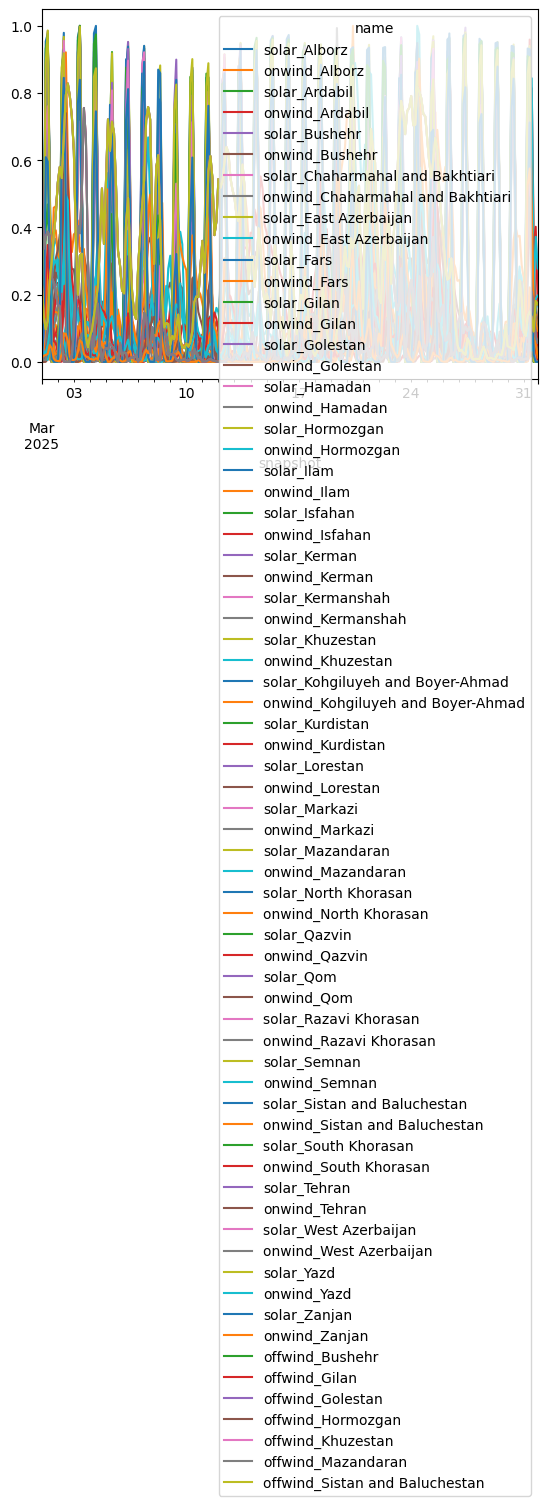

In [82]:
n.generators_t.p_max_pu.loc["2025-03"].plot()

In [83]:
n.statistics.energy_balance.iplot()

## Exporting the model as ".nc" file

In [84]:
n.export_to_netcdf("pypsa_model_n.nc")

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'pypsa_model_n.nc contains: storage_units, generators, loads, links, buses, sub_networks, carriers


<xarray.Dataset> Size: 14MB
Dimensions:                            (snapshots: 2920, storage_units_i: 186,
                                        storage_units_t_p_i: 5,
                                        storage_units_t_p_dispatch_i: 5,
                                        storage_units_t_p_store_i: 5,
                                        storage_units_t_state_of_charge_i: 186,
                                        generators_i: 119,
                                        ...
                                        loads_t_p_set_i: 31, loads_t_p_i: 31,
                                        links_i: 74, links_t_p0_i: 51,
                                        links_t_p1_i: 51, buses_i: 31,
                                        buses_t_p_i: 31,
                                        buses_t_marginal_price_i: 31,
                                        sub_networks_i: 31, carriers_i: 10)
Coordinates: (12/20)
  * snapshots                          (snapshots) int64 23kB 0 1 ... 2918 2919
  * storage_units_i                    (storage_units_i) object 1kB 'battery_...
  * storage_units_t_p_i                (storage_units_t_p_i) object 40B 'batt...
  * storage_units_t_p_dispatch_i       (storage_units_t_p_dispatch_i) object 40B ...
  * storage_units_t_p_store_i          (storage_units_t_p_store_i) object 40B ...
  * storage_units_t_state_of_charge_i  (storage_units_t_state_of_charge_i) object 1kB ...
    ...                                 ...
  * links_t_p1_i                       (links_t_p1_i) object 408B 'line_Albor...
  * buses_i                            (buses_i) object 248B 'Alborz' ... 'Za...
  * buses_t_p_i                        (buses_t_p_i) object 248B 'Alborz' ......
  * buses_t_marginal_price_i           (buses_t_marginal_price_i) object 248B ...
  * sub_networks_i                     (sub_networks_i) object 248B '0' ... '30'
  * carriers_i                         (carriers_i) object 80B 'AC' ... 'H2'
Data variables: (12/51)
    snapshots_snapshot                 (snapshots) datetime64[ns] 23kB 2025-0...
    snapshots_objective                (snapshots) float64 23kB 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 23kB 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 23kB 1.0 1.0 ... 1.0
    storage_units_bus                  (storage_units_i) object 1kB 'Alborz' ...
    storage_units_p_nom_extendable     (storage_units_i) bool 186B True ... True
    ...                                 ...
    buses_t_p                          (snapshots, buses_t_p_i) float64 724kB ...
    buses_t_marginal_price             (snapshots, buses_t_marginal_price_i) float64 724kB ...
    sub_networks_slack_bus             (sub_networks_i) object 248B 'Alborz' ...
    sub_networks_obj                   (sub_networks_i) float64 248B nan ... nan
    carriers_co2_emissions             (carriers_i) float64 80B 0.0 ... 0.0
    carriers_color                     (carriers_i) object 80B 'black' ... 'm...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           1427189439.7356813
    network__objective_constant:  0.0
    network_name:                 Unnamed Network
    network_pypsa_version:        1.0.5
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}

## creating a new model "n_no_co2" and adding co2 limit

In [86]:
n.model.solver_model = None
n_no_co2 = n.copy()

In [92]:
n_no_co2.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0
)

In [93]:
# solve the model
#n.optimize(solver_name="highs")
n_no_co2.optimize(
    #snapshots=n.snapshots[:168],  # 1 week
    solver_name="gurobi"
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 49.34it/s]
INFO:linopy.io: Writing time: 3.89s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2750042


INFO:gurobipy:Set parameter LicenseID to value 2750042


Academic license - for non-commercial use only - expires 2026-12-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-12-04


Read LP format model from file /private/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/linopy-problem-4o3scxty.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/linopy-problem-4o3scxty.lp


Reading time = 4.41 seconds


INFO:gurobipy:Reading time = 4.41 seconds


obj: 5019879 rows, 2193249 columns, 10762913 nonzeros


INFO:gurobipy:obj: 5019879 rows, 2193249 columns, 10762913 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 14 physical cores, 14 logical processors, using up to 14 threads


INFO:gurobipy:Thread count: 14 physical cores, 14 logical processors, using up to 14 threads


INFO:gurobipy:


Optimize a model with 5019879 rows, 2193249 columns and 10762913 nonzeros (Min)


INFO:gurobipy:Optimize a model with 5019879 rows, 2193249 columns and 10762913 nonzeros (Min)


Model fingerprint: 0xeafeb2d3


INFO:gurobipy:Model fingerprint: 0xeafeb2d3


Model has 318609 linear objective coefficients


INFO:gurobipy:Model has 318609 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 7e+02]


INFO:gurobipy:  Matrix range     [2e-10, 7e+02]


  Objective range  [1e-02, 1e+07]


INFO:gurobipy:  Objective range  [1e-02, 1e+07]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+00, 4e+05]


INFO:gurobipy:  RHS range        [2e+00, 4e+05]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 2377884 rows and 152445 columns (presolve time = 6s)...


INFO:gurobipy:Presolve removed 2377884 rows and 152445 columns (presolve time = 6s)...


Presolve removed 2377884 rows and 152445 columns


INFO:gurobipy:Presolve removed 2377884 rows and 152445 columns


Presolve time: 7.73s


INFO:gurobipy:Presolve time: 7.73s


Presolved: 2641995 rows, 2040804 columns, 8334785 nonzeros


INFO:gurobipy:Presolved: 2641995 rows, 2040804 columns, 8334785 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 9.47s


INFO:gurobipy:Ordering time: 9.47s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 329


INFO:gurobipy: Dense cols : 329


 AA' NZ     : 7.597e+06


INFO:gurobipy: AA' NZ     : 7.597e+06


 Factor NZ  : 6.784e+07 (roughly 2.4 GB of memory)


INFO:gurobipy: Factor NZ  : 6.784e+07 (roughly 2.4 GB of memory)


 Factor Ops : 2.394e+10 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.394e+10 (less than 1 second per iteration)


 Threads    : 12


INFO:gurobipy: Threads    : 12


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.95020705e+12 -1.32666814e+11  6.44e+05 1.59e+01  9.11e+08    19s


INFO:gurobipy:   0   1.95020705e+12 -1.32666814e+11  6.44e+05 1.59e+01  9.11e+08    19s


   1   2.95626371e+12 -1.45384240e+11  4.93e+05 6.86e+03  8.10e+08    20s


INFO:gurobipy:   1   2.95626371e+12 -1.45384240e+11  4.93e+05 6.86e+03  8.10e+08    20s


   2   3.35092123e+12 -3.85589755e+11  4.47e+05 5.43e+03  6.75e+08    20s


INFO:gurobipy:   2   3.35092123e+12 -3.85589755e+11  4.47e+05 5.43e+03  6.75e+08    20s


   3   3.61474349e+12 -6.74035445e+11  4.18e+05 4.16e+03  5.51e+08    21s


INFO:gurobipy:   3   3.61474349e+12 -6.74035445e+11  4.18e+05 4.16e+03  5.51e+08    21s


   4   4.88636813e+12 -1.86976591e+12  2.94e+05 2.34e+03  3.39e+08    21s


INFO:gurobipy:   4   4.88636813e+12 -1.86976591e+12  2.94e+05 2.34e+03  3.39e+08    21s


   5   9.34874567e+12 -2.49558745e+12  1.39e+05 9.45e+02  1.48e+08    22s


INFO:gurobipy:   5   9.34874567e+12 -2.49558745e+12  1.39e+05 9.45e+02  1.48e+08    22s


   6   1.31441434e+13 -2.46558491e+12  6.32e+04 3.09e+02  5.28e+07    23s


INFO:gurobipy:   6   1.31441434e+13 -2.46558491e+12  6.32e+04 3.09e+02  5.28e+07    23s


   7   1.33538135e+13 -2.13046446e+12  3.40e+04 1.13e+02  2.26e+07    24s


INFO:gurobipy:   7   1.33538135e+13 -2.13046446e+12  3.40e+04 1.13e+02  2.26e+07    24s


   8   1.19331686e+13 -1.92504641e+12  2.13e+04 8.26e+01  1.58e+07    24s


INFO:gurobipy:   8   1.19331686e+13 -1.92504641e+12  2.13e+04 8.26e+01  1.58e+07    24s


   9   9.69851542e+12 -1.51980058e+12  1.44e+04 4.34e+01  9.28e+06    25s


INFO:gurobipy:   9   9.69851542e+12 -1.51980058e+12  1.44e+04 4.34e+01  9.28e+06    25s


  10   7.43862493e+12 -1.28395051e+12  9.03e+03 2.74e+01  5.90e+06    25s


INFO:gurobipy:  10   7.43862493e+12 -1.28395051e+12  9.03e+03 2.74e+01  5.90e+06    25s


  11   4.98751800e+12 -1.00348528e+12  4.70e+03 1.72e+01  3.42e+06    26s


INFO:gurobipy:  11   4.98751800e+12 -1.00348528e+12  4.70e+03 1.72e+01  3.42e+06    26s


  12   2.97913639e+12 -7.35416357e+11  2.15e+03 1.07e+01  1.84e+06    26s


INFO:gurobipy:  12   2.97913639e+12 -7.35416357e+11  2.15e+03 1.07e+01  1.84e+06    26s


  13   2.28084452e+12 -4.54646430e+11  1.49e+03 5.44e+00  1.12e+06    26s


INFO:gurobipy:  13   2.28084452e+12 -4.54646430e+11  1.49e+03 5.44e+00  1.12e+06    26s


  14   1.53717845e+12 -3.06397697e+11  8.58e+02 3.30e+00  6.74e+05    27s


INFO:gurobipy:  14   1.53717845e+12 -3.06397697e+11  8.58e+02 3.30e+00  6.74e+05    27s


  15   1.12517042e+12 -1.93009413e+11  5.71e+02 1.86e+00  4.34e+05    27s


INFO:gurobipy:  15   1.12517042e+12 -1.93009413e+11  5.71e+02 1.86e+00  4.34e+05    27s


  16   7.97746265e+11 -1.15735702e+11  3.77e+02 1.01e+00  2.77e+05    28s


INFO:gurobipy:  16   7.97746265e+11 -1.15735702e+11  3.77e+02 1.01e+00  2.77e+05    28s


  17   4.51523213e+11 -6.59812766e+10  1.91e+02 5.28e-01  1.46e+05    28s


INFO:gurobipy:  17   4.51523213e+11 -6.59812766e+10  1.91e+02 5.28e-01  1.46e+05    28s


  18   2.59021806e+11 -3.94721572e+10  1.04e+02 2.83e-01  8.05e+04    29s


INFO:gurobipy:  18   2.59021806e+11 -3.94721572e+10  1.04e+02 2.83e-01  8.05e+04    29s


  19   1.54767784e+11 -2.64353446e+10  5.88e+01 1.71e-01  4.76e+04    29s


INFO:gurobipy:  19   1.54767784e+11 -2.64353446e+10  5.88e+01 1.71e-01  4.76e+04    29s


  20   9.43788642e+10 -1.93447904e+10  3.46e+01 1.18e-01  2.94e+04    30s


INFO:gurobipy:  20   9.43788642e+10 -1.93447904e+10  3.46e+01 1.18e-01  2.94e+04    30s


  21   6.24525164e+10 -1.31526200e+10  2.22e+01 7.40e-02  1.92e+04    30s


INFO:gurobipy:  21   6.24525164e+10 -1.31526200e+10  2.22e+01 7.40e-02  1.92e+04    30s


  22   5.05333153e+10 -8.05145746e+09  1.77e+01 3.98e-02  1.48e+04    31s


INFO:gurobipy:  22   5.05333153e+10 -8.05145746e+09  1.77e+01 3.98e-02  1.48e+04    31s


  23   4.09068852e+10 -6.52753111e+09  1.42e+01 3.18e-02  1.19e+04    31s


INFO:gurobipy:  23   4.09068852e+10 -6.52753111e+09  1.42e+01 3.18e-02  1.19e+04    31s


  24   3.51059065e+10 -5.17995855e+09  1.21e+01 2.48e-02  1.01e+04    32s


INFO:gurobipy:  24   3.51059065e+10 -5.17995855e+09  1.21e+01 2.48e-02  1.01e+04    32s


  25   2.30435979e+10 -2.47301404e+09  7.78e+00 1.07e-02  6.34e+03    33s


INFO:gurobipy:  25   2.30435979e+10 -2.47301404e+09  7.78e+00 1.07e-02  6.34e+03    33s


  26   1.78999090e+10 -1.31687597e+09  5.90e+00 6.10e-03  4.76e+03    33s


INFO:gurobipy:  26   1.78999090e+10 -1.31687597e+09  5.90e+00 6.10e-03  4.76e+03    33s


  27   1.74666376e+10 -1.10993729e+09  5.74e+00 5.64e-03  4.60e+03    34s


INFO:gurobipy:  27   1.74666376e+10 -1.10993729e+09  5.74e+00 5.64e-03  4.60e+03    34s


  28   1.44019416e+10 -1.45426973e+08  4.60e+00 3.12e-03  3.59e+03    35s


INFO:gurobipy:  28   1.44019416e+10 -1.45426973e+08  4.60e+00 3.12e-03  3.59e+03    35s


  29   1.21238073e+10  6.42974875e+08  3.72e+00 1.36e-03  2.83e+03    36s


INFO:gurobipy:  29   1.21238073e+10  6.42974875e+08  3.72e+00 1.36e-03  2.83e+03    36s


  30   8.87108658e+09  9.09707921e+08  2.49e+00 9.70e-04  1.96e+03    36s


INFO:gurobipy:  30   8.87108658e+09  9.09707921e+08  2.49e+00 9.70e-04  1.96e+03    36s


  31   8.11561150e+09  1.25422752e+09  2.17e+00 7.21e-04  1.69e+03    37s


INFO:gurobipy:  31   8.11561150e+09  1.25422752e+09  2.17e+00 7.21e-04  1.69e+03    37s


  32   7.58431283e+09  1.67925089e+09  1.91e+00 6.32e-04  1.45e+03    38s


INFO:gurobipy:  32   7.58431283e+09  1.67925089e+09  1.91e+00 6.32e-04  1.45e+03    38s


  33   7.10798063e+09  2.08926646e+09  1.64e+00 5.16e-04  1.23e+03    38s


INFO:gurobipy:  33   7.10798063e+09  2.08926646e+09  1.64e+00 5.16e-04  1.23e+03    38s


  34   6.94637244e+09  2.40932506e+09  1.55e+00 4.37e-04  1.12e+03    39s


INFO:gurobipy:  34   6.94637244e+09  2.40932506e+09  1.55e+00 4.37e-04  1.12e+03    39s


  35   6.45822380e+09  2.67209337e+09  1.30e+00 3.61e-04  9.32e+02    40s


INFO:gurobipy:  35   6.45822380e+09  2.67209337e+09  1.30e+00 3.61e-04  9.32e+02    40s


  36   6.19401091e+09  2.94745795e+09  1.16e+00 2.97e-04  8.00e+02    41s


INFO:gurobipy:  36   6.19401091e+09  2.94745795e+09  1.16e+00 2.97e-04  8.00e+02    41s


  37   6.09542424e+09  3.11158421e+09  1.11e+00 2.55e-04  7.36e+02    41s


INFO:gurobipy:  37   6.09542424e+09  3.11158421e+09  1.11e+00 2.55e-04  7.36e+02    41s


  38   5.92399185e+09  3.24500171e+09  1.02e+00 2.08e-04  6.61e+02    42s


INFO:gurobipy:  38   5.92399185e+09  3.24500171e+09  1.02e+00 2.08e-04  6.61e+02    42s


  39   5.57627764e+09  3.36599012e+09  8.40e-01 1.65e-04  5.45e+02    43s


INFO:gurobipy:  39   5.57627764e+09  3.36599012e+09  8.40e-01 1.65e-04  5.45e+02    43s


  40   5.44960044e+09  3.44494598e+09  7.79e-01 1.46e-04  4.95e+02    43s


INFO:gurobipy:  40   5.44960044e+09  3.44494598e+09  7.79e-01 1.46e-04  4.95e+02    43s


  41   5.33872919e+09  3.48858312e+09  7.24e-01 1.36e-04  4.57e+02    44s


INFO:gurobipy:  41   5.33872919e+09  3.48858312e+09  7.24e-01 1.36e-04  4.57e+02    44s


  42   5.18147587e+09  3.52101944e+09  6.49e-01 1.30e-04  4.10e+02    45s


INFO:gurobipy:  42   5.18147587e+09  3.52101944e+09  6.49e-01 1.30e-04  4.10e+02    45s


  43   5.08908595e+09  3.57266456e+09  6.03e-01 1.13e-04  3.74e+02    46s


INFO:gurobipy:  43   5.08908595e+09  3.57266456e+09  6.03e-01 1.13e-04  3.74e+02    46s


  44   4.93101999e+09  3.61118140e+09  5.26e-01 9.84e-05  3.26e+02    46s


INFO:gurobipy:  44   4.93101999e+09  3.61118140e+09  5.26e-01 9.84e-05  3.26e+02    46s


  45   4.84874964e+09  3.64874671e+09  4.85e-01 8.46e-05  2.96e+02    47s


INFO:gurobipy:  45   4.84874964e+09  3.64874671e+09  4.85e-01 8.46e-05  2.96e+02    47s


  46   4.71213481e+09  3.68276828e+09  4.18e-01 7.12e-05  2.54e+02    48s


INFO:gurobipy:  46   4.71213481e+09  3.68276828e+09  4.18e-01 7.12e-05  2.54e+02    48s


  47   4.61209164e+09  3.72111404e+09  3.70e-01 6.20e-05  2.20e+02    48s


INFO:gurobipy:  47   4.61209164e+09  3.72111404e+09  3.70e-01 6.20e-05  2.20e+02    48s


  48   4.50365650e+09  3.75897880e+09  3.16e-01 4.32e-05  1.84e+02    49s


INFO:gurobipy:  48   4.50365650e+09  3.75897880e+09  3.16e-01 4.32e-05  1.84e+02    49s


  49   4.45482346e+09  3.76602538e+09  2.93e-01 3.94e-05  1.70e+02    50s


INFO:gurobipy:  49   4.45482346e+09  3.76602538e+09  2.93e-01 3.94e-05  1.70e+02    50s


  50   4.38352259e+09  3.78443671e+09  2.58e-01 2.95e-05  1.48e+02    51s


INFO:gurobipy:  50   4.38352259e+09  3.78443671e+09  2.58e-01 2.95e-05  1.48e+02    51s


  51   4.30846446e+09  3.79736013e+09  2.19e-01 2.27e-05  1.26e+02    51s


INFO:gurobipy:  51   4.30846446e+09  3.79736013e+09  2.19e-01 2.27e-05  1.26e+02    51s


  52   4.22885391e+09  3.81784989e+09  1.80e-01 1.28e-05  1.02e+02    52s


INFO:gurobipy:  52   4.22885391e+09  3.81784989e+09  1.80e-01 1.28e-05  1.02e+02    52s


  53   4.17807866e+09  3.83219119e+09  1.54e-01 5.97e-06  8.56e+01    53s


INFO:gurobipy:  53   4.17807866e+09  3.83219119e+09  1.54e-01 5.97e-06  8.56e+01    53s


  54   4.12759735e+09  3.83880477e+09  1.30e-01 4.45e-06  7.15e+01    54s


INFO:gurobipy:  54   4.12759735e+09  3.83880477e+09  1.30e-01 4.45e-06  7.15e+01    54s


  55   4.08865808e+09  3.84432795e+09  1.11e-01 3.31e-06  6.05e+01    55s


INFO:gurobipy:  55   4.08865808e+09  3.84432795e+09  1.11e-01 3.31e-06  6.05e+01    55s


  56   4.05865496e+09  3.84920662e+09  9.57e-02 1.69e-06  5.18e+01    55s


INFO:gurobipy:  56   4.05865496e+09  3.84920662e+09  9.57e-02 1.69e-06  5.18e+01    55s


  57   4.02130510e+09  3.85169973e+09  7.70e-02 9.90e-07  4.20e+01    56s


INFO:gurobipy:  57   4.02130510e+09  3.85169973e+09  7.70e-02 9.90e-07  4.20e+01    56s


  58   4.01825014e+09  3.85325840e+09  7.54e-02 9.07e-07  4.08e+01    57s


INFO:gurobipy:  58   4.01825014e+09  3.85325840e+09  7.54e-02 9.07e-07  4.08e+01    57s


  59   3.99415148e+09  3.85660041e+09  6.36e-02 1.52e-07  3.41e+01    58s


INFO:gurobipy:  59   3.99415148e+09  3.85660041e+09  6.36e-02 1.52e-07  3.41e+01    58s


  60   3.97724692e+09  3.85855080e+09  5.49e-02 7.73e-08  2.94e+01    58s


INFO:gurobipy:  60   3.97724692e+09  3.85855080e+09  5.49e-02 7.73e-08  2.94e+01    58s


  61   3.96573228e+09  3.86085935e+09  4.91e-02 1.82e-07  2.60e+01    59s


INFO:gurobipy:  61   3.96573228e+09  3.86085935e+09  4.91e-02 1.82e-07  2.60e+01    59s


  62   3.94418138e+09  3.86277317e+09  3.91e-02 2.98e-07  2.02e+01    60s


INFO:gurobipy:  62   3.94418138e+09  3.86277317e+09  3.91e-02 2.98e-07  2.02e+01    60s


  63   3.93569980e+09  3.86426329e+09  3.47e-02 4.64e-07  1.77e+01    61s


INFO:gurobipy:  63   3.93569980e+09  3.86426329e+09  3.47e-02 4.64e-07  1.77e+01    61s


  64   3.92765146e+09  3.86565665e+09  3.03e-02 6.10e-07  1.54e+01    62s


INFO:gurobipy:  64   3.92765146e+09  3.86565665e+09  3.03e-02 6.10e-07  1.54e+01    62s


  65   3.91624128e+09  3.86641784e+09  2.45e-02 8.24e-07  1.24e+01    62s


INFO:gurobipy:  65   3.91624128e+09  3.86641784e+09  2.45e-02 8.24e-07  1.24e+01    62s


  66   3.90357598e+09  3.86733099e+09  1.79e-02 9.87e-07  8.99e+00    63s


INFO:gurobipy:  66   3.90357598e+09  3.86733099e+09  1.79e-02 9.87e-07  8.99e+00    63s


  67   3.89897486e+09  3.86774336e+09  1.54e-02 9.77e-07  7.74e+00    64s


INFO:gurobipy:  67   3.89897486e+09  3.86774336e+09  1.54e-02 9.77e-07  7.74e+00    64s


  68   3.89455825e+09  3.86820034e+09  1.30e-02 9.73e-07  6.54e+00    65s


INFO:gurobipy:  68   3.89455825e+09  3.86820034e+09  1.30e-02 9.73e-07  6.54e+00    65s


  69   3.89058491e+09  3.86861352e+09  1.09e-02 8.61e-07  5.45e+00    66s


INFO:gurobipy:  69   3.89058491e+09  3.86861352e+09  1.09e-02 8.61e-07  5.45e+00    66s


  70   3.88855046e+09  3.86885494e+09  9.84e-03 7.26e-07  4.89e+00    67s


INFO:gurobipy:  70   3.88855046e+09  3.86885494e+09  9.84e-03 7.26e-07  4.89e+00    67s


  71   3.88654678e+09  3.86900784e+09  8.79e-03 7.25e-07  4.35e+00    68s


INFO:gurobipy:  71   3.88654678e+09  3.86900784e+09  8.79e-03 7.25e-07  4.35e+00    68s


  72   3.88468843e+09  3.86923039e+09  7.79e-03 8.56e-07  3.84e+00    68s


INFO:gurobipy:  72   3.88468843e+09  3.86923039e+09  7.79e-03 8.56e-07  3.84e+00    68s


  73   3.88048303e+09  3.86944112e+09  5.56e-03 9.70e-07  2.74e+00    69s


INFO:gurobipy:  73   3.88048303e+09  3.86944112e+09  5.56e-03 9.70e-07  2.74e+00    69s


  74   3.87859764e+09  3.86962184e+09  4.57e-03 1.37e-06  2.23e+00    70s


INFO:gurobipy:  74   3.87859764e+09  3.86962184e+09  4.57e-03 1.37e-06  2.23e+00    70s


  75   3.87721155e+09  3.86975722e+09  3.80e-03 1.48e-06  1.85e+00    71s


INFO:gurobipy:  75   3.87721155e+09  3.86975722e+09  3.80e-03 1.48e-06  1.85e+00    71s


  76   3.87616719e+09  3.86984546e+09  3.23e-03 1.56e-06  1.57e+00    72s


INFO:gurobipy:  76   3.87616719e+09  3.86984546e+09  3.23e-03 1.56e-06  1.57e+00    72s


  77   3.87559800e+09  3.86999271e+09  2.92e-03 1.68e-06  1.39e+00    73s


INFO:gurobipy:  77   3.87559800e+09  3.86999271e+09  2.92e-03 1.68e-06  1.39e+00    73s


  78   3.87435902e+09  3.87007312e+09  2.21e-03 2.07e-06  1.06e+00    74s


INFO:gurobipy:  78   3.87435902e+09  3.87007312e+09  2.21e-03 2.07e-06  1.06e+00    74s


  79   3.87322502e+09  3.87011154e+09  1.58e-03 2.27e-06  7.72e-01    75s


INFO:gurobipy:  79   3.87322502e+09  3.87011154e+09  1.58e-03 2.27e-06  7.72e-01    75s


  80   3.87290487e+09  3.87013400e+09  1.41e-03 2.10e-06  6.87e-01    76s


INFO:gurobipy:  80   3.87290487e+09  3.87013400e+09  1.41e-03 2.10e-06  6.87e-01    76s


  81   3.87252659e+09  3.87017071e+09  1.21e-03 2.16e-06  5.85e-01    77s


INFO:gurobipy:  81   3.87252659e+09  3.87017071e+09  1.21e-03 2.16e-06  5.85e-01    77s


  82   3.87224639e+09  3.87020961e+09  1.05e-03 2.22e-06  5.06e-01    78s


INFO:gurobipy:  82   3.87224639e+09  3.87020961e+09  1.05e-03 2.22e-06  5.06e-01    78s


  83   3.87193971e+09  3.87023312e+09  8.86e-04 1.88e-06  4.24e-01    79s


INFO:gurobipy:  83   3.87193971e+09  3.87023312e+09  8.86e-04 1.88e-06  4.24e-01    79s


  84   3.87163203e+09  3.87024500e+09  7.21e-04 1.81e-06  3.44e-01    80s


INFO:gurobipy:  84   3.87163203e+09  3.87024500e+09  7.21e-04 1.81e-06  3.44e-01    80s


  85   3.87131010e+09  3.87025681e+09  5.51e-04 1.55e-06  2.62e-01    81s


INFO:gurobipy:  85   3.87131010e+09  3.87025681e+09  5.51e-04 1.55e-06  2.62e-01    81s


  86   3.87098434e+09  3.87026596e+09  3.70e-04 2.24e-06  1.78e-01    82s


INFO:gurobipy:  86   3.87098434e+09  3.87026596e+09  3.70e-04 2.24e-06  1.78e-01    82s


  87   3.87086573e+09  3.87026831e+09  3.07e-04 1.89e-06  1.48e-01    83s


INFO:gurobipy:  87   3.87086573e+09  3.87026831e+09  3.07e-04 1.89e-06  1.48e-01    83s


  88   3.87076791e+09  3.87027139e+09  2.59e-04 4.35e-06  1.23e-01    84s


INFO:gurobipy:  88   3.87076791e+09  3.87027139e+09  2.59e-04 4.35e-06  1.23e-01    84s


  89   3.87071431e+09  3.87027512e+09  2.31e-04 3.95e-06  1.09e-01    85s


INFO:gurobipy:  89   3.87071431e+09  3.87027512e+09  2.31e-04 3.95e-06  1.09e-01    85s


  90   3.87065773e+09  3.87027700e+09  2.03e-04 3.26e-06  9.46e-02    86s


INFO:gurobipy:  90   3.87065773e+09  3.87027700e+09  2.03e-04 3.26e-06  9.46e-02    86s


  91   3.87053510e+09  3.87027790e+09  1.35e-04 2.59e-06  6.39e-02    87s


INFO:gurobipy:  91   3.87053510e+09  3.87027790e+09  1.35e-04 2.59e-06  6.39e-02    87s


  92   3.87049486e+09  3.87028024e+09  1.14e-04 5.88e-07  5.33e-02    88s


INFO:gurobipy:  92   3.87049486e+09  3.87028024e+09  1.14e-04 5.88e-07  5.33e-02    88s


  93   3.87042358e+09  3.87028090e+09  7.60e-05 6.41e-07  3.54e-02    89s


INFO:gurobipy:  93   3.87042358e+09  3.87028090e+09  7.60e-05 6.41e-07  3.54e-02    89s


  94   3.87040337e+09  3.87028174e+09  6.54e-05 1.49e-06  3.02e-02    90s


INFO:gurobipy:  94   3.87040337e+09  3.87028174e+09  6.54e-05 1.49e-06  3.02e-02    90s


  95   3.87035871e+09  3.87028211e+09  6.01e-05 8.35e-07  1.90e-02    91s


INFO:gurobipy:  95   3.87035871e+09  3.87028211e+09  6.01e-05 8.35e-07  1.90e-02    91s


  96   3.87034024e+09  3.87028247e+09  4.54e-05 2.39e-07  1.43e-02    92s


INFO:gurobipy:  96   3.87034024e+09  3.87028247e+09  4.54e-05 2.39e-07  1.43e-02    92s


  97   3.87033685e+09  3.87028265e+09  4.58e-05 1.70e-07  1.34e-02    92s


INFO:gurobipy:  97   3.87033685e+09  3.87028265e+09  4.58e-05 1.70e-07  1.34e-02    92s


  98   3.87032390e+09  3.87028273e+09  4.87e-05 8.41e-08  1.02e-02    93s


INFO:gurobipy:  98   3.87032390e+09  3.87028273e+09  4.87e-05 8.41e-08  1.02e-02    93s


  99   3.87031216e+09  3.87028282e+09  5.13e-05 8.21e-08  7.27e-03    94s


INFO:gurobipy:  99   3.87031216e+09  3.87028282e+09  5.13e-05 8.21e-08  7.27e-03    94s


 100   3.87029682e+09  3.87028289e+09  3.85e-05 3.48e-07  3.44e-03    94s


INFO:gurobipy: 100   3.87029682e+09  3.87028289e+09  3.85e-05 3.48e-07  3.44e-03    94s


 101   3.87029503e+09  3.87028294e+09  3.30e-05 2.52e-07  2.99e-03    95s


INFO:gurobipy: 101   3.87029503e+09  3.87028294e+09  3.30e-05 2.52e-07  2.99e-03    95s


 102   3.87029088e+09  3.87028308e+09  2.14e-05 3.48e-07  1.93e-03    95s


INFO:gurobipy: 102   3.87029088e+09  3.87028308e+09  2.14e-05 3.48e-07  1.93e-03    95s


 103   3.87028492e+09  3.87028315e+09  6.41e-06 1.31e-07  4.33e-04    96s


INFO:gurobipy: 103   3.87028492e+09  3.87028315e+09  6.41e-06 1.31e-07  4.33e-04    96s


 104   3.87028343e+09  3.87028321e+09  1.95e-06 5.88e-07  5.53e-05    96s


INFO:gurobipy: 104   3.87028343e+09  3.87028321e+09  1.95e-06 5.88e-07  5.53e-05    96s


 105   3.87028325e+09  3.87028322e+09  4.15e-07 5.33e-08  8.07e-06    97s


INFO:gurobipy: 105   3.87028325e+09  3.87028322e+09  4.15e-07 5.33e-08  8.07e-06    97s


 106   3.87028322e+09  3.87028322e+09  3.38e-08 1.58e-08  3.30e-07    97s


INFO:gurobipy: 106   3.87028322e+09  3.87028322e+09  3.38e-08 1.58e-08  3.30e-07    97s


 107   3.87028322e+09  3.87028322e+09  2.50e-07 3.82e-08  2.62e-08    98s


INFO:gurobipy: 107   3.87028322e+09  3.87028322e+09  2.50e-07 3.82e-08  2.62e-08    98s


 108   3.87028322e+09  3.87028322e+09  1.97e-10 5.66e-08  1.12e-11    98s


INFO:gurobipy: 108   3.87028322e+09  3.87028322e+09  1.97e-10 5.66e-08  1.12e-11    98s


INFO:gurobipy:


Barrier solved model in 108 iterations and 98.50 seconds (207.92 work units)


INFO:gurobipy:Barrier solved model in 108 iterations and 98.50 seconds (207.92 work units)


Optimal objective 3.87028322e+09


INFO:gurobipy:Optimal objective 3.87028322e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  454872 DPushes remaining with DInf 1.1591002e-04               100s


INFO:gurobipy:  454872 DPushes remaining with DInf 1.1591002e-04               100s


   59327 DPushes remaining with DInf 0.0000000e+00               101s


INFO:gurobipy:   59327 DPushes remaining with DInf 0.0000000e+00               101s


       0 DPushes remaining with DInf 0.0000000e+00               103s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               103s


INFO:gurobipy:


  156223 PPushes remaining with PInf 2.1749762e-02               103s


INFO:gurobipy:  156223 PPushes remaining with PInf 2.1749762e-02               103s


   80424 PPushes remaining with PInf 9.5570532e-03               189s


INFO:gurobipy:   80424 PPushes remaining with PInf 9.5570532e-03               189s


   43730 PPushes remaining with PInf 3.2579243e-03               243s


INFO:gurobipy:   43730 PPushes remaining with PInf 3.2579243e-03               243s


   29536 PPushes remaining with PInf 1.8548218e-03               257s


INFO:gurobipy:   29536 PPushes remaining with PInf 1.8548218e-03               257s


   23084 PPushes remaining with PInf 1.4316992e-03               267s


INFO:gurobipy:   23084 PPushes remaining with PInf 1.4316992e-03               267s


   18717 PPushes remaining with PInf 1.0509405e-03               275s


INFO:gurobipy:   18717 PPushes remaining with PInf 1.0509405e-03               275s


   15550 PPushes remaining with PInf 8.7152313e-04               282s


INFO:gurobipy:   15550 PPushes remaining with PInf 8.7152313e-04               282s


   12764 PPushes remaining with PInf 7.6204000e-04               287s


INFO:gurobipy:   12764 PPushes remaining with PInf 7.6204000e-04               287s


   10232 PPushes remaining with PInf 6.1305148e-04               292s


INFO:gurobipy:   10232 PPushes remaining with PInf 6.1305148e-04               292s


    8093 PPushes remaining with PInf 4.2201775e-04               296s


INFO:gurobipy:    8093 PPushes remaining with PInf 4.2201775e-04               296s


    4489 PPushes remaining with PInf 2.1373885e-04               303s


INFO:gurobipy:    4489 PPushes remaining with PInf 2.1373885e-04               303s


       0 PPushes remaining with PInf 0.0000000e+00               303s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               303s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.2887430e-09    303s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.2887430e-09    303s


INFO:gurobipy:


Crossover time: 204.84 seconds (322.42 work units)


INFO:gurobipy:Crossover time: 204.84 seconds (322.42 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  601147    3.8702832e+09   0.000000e+00   0.000000e+00    305s


INFO:gurobipy:  601147    3.8702832e+09   0.000000e+00   0.000000e+00    305s


INFO:gurobipy:


Solved in 601147 iterations and 305.28 seconds (532.39 work units)


INFO:gurobipy:Solved in 601147 iterations and 305.28 seconds (532.39 work units)


Optimal objective  3.870283219e+09


INFO:gurobipy:Optimal objective  3.870283219e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2193249 primals, 5019879 duals
Objective: 3.87e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

## Exporting the model with CO2 Limit as ".nc" file

In [94]:
n_no_co2.export_to_netcdf("pypsa_model_n_no_co2.nc")

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'pypsa_model_n_no_co2.nc contains: storage_units, generators, loads, links, global_constraints, buses, sub_networks, carriers


<xarray.Dataset> Size: 15MB
Dimensions:                            (snapshots: 2920, storage_units_i: 186,
                                        storage_units_t_p_i: 28,
                                        storage_units_t_p_dispatch_i: 28,
                                        storage_units_t_p_store_i: 28,
                                        storage_units_t_state_of_charge_i: 186,
                                        generators_i: 119,
                                        ...
                                        links_i: 74, links_t_p0_i: 41,
                                        links_t_p1_i: 41,
                                        global_constraints_i: 1, buses_i: 31,
                                        buses_t_p_i: 31,
                                        buses_t_marginal_price_i: 31,
                                        sub_networks_i: 31, carriers_i: 10)
Coordinates: (12/21)
  * snapshots                          (snapshots) int64 23kB 0 1 ... 2918 2919
  * storage_units_i                    (storage_units_i) object 1kB 'battery_...
  * storage_units_t_p_i                (storage_units_t_p_i) object 224B 'bat...
  * storage_units_t_p_dispatch_i       (storage_units_t_p_dispatch_i) object 224B ...
  * storage_units_t_p_store_i          (storage_units_t_p_store_i) object 224B ...
  * storage_units_t_state_of_charge_i  (storage_units_t_state_of_charge_i) object 1kB ...
    ...                                 ...
  * global_constraints_i               (global_constraints_i) object 8B 'CO2L...
  * buses_i                            (buses_i) object 248B 'Alborz' ... 'Za...
  * buses_t_p_i                        (buses_t_p_i) object 248B 'Alborz' ......
  * buses_t_marginal_price_i           (buses_t_marginal_price_i) object 248B ...
  * sub_networks_i                     (sub_networks_i) object 248B '0' ... '30'
  * carriers_i                         (carriers_i) object 80B 'AC' ... 'H2'
Data variables: (12/53)
    snapshots_snapshot                 (snapshots) datetime64[ns] 23kB 2025-0...
    snapshots_objective                (snapshots) float64 23kB 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 23kB 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 23kB 1.0 1.0 ... 1.0
    storage_units_bus                  (storage_units_i) object 1kB 'Alborz' ...
    storage_units_p_nom_extendable     (storage_units_i) bool 186B True ... True
    ...                                 ...
    buses_t_p                          (snapshots, buses_t_p_i) float64 724kB ...
    buses_t_marginal_price             (snapshots, buses_t_marginal_price_i) float64 724kB ...
    sub_networks_slack_bus             (sub_networks_i) object 248B 'Alborz' ...
    sub_networks_obj                   (sub_networks_i) float64 248B nan ... nan
    carriers_co2_emissions             (carriers_i) float64 80B 0.0 ... 0.0
    carriers_color                     (carriers_i) object 80B 'black' ... 'm...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           3870283218.5955033
    network__objective_constant:  0.0
    network_name:                 Unnamed Network
    network_pypsa_version:        1.0.5
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}

In [96]:
n_no_co2.statistics.energy_balance.iplot()